# Explorative analysis of dataset

## Preparation

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# seaborn may cause bugs in pyplot (e.g. hiding outliers in boxplot)
import seaborn as sns
from datetime import datetime

In [2]:
# set default figsize
plt.rcParams['figure.figsize'] = [15, 6]

In [3]:
df_projects = pd.read_csv('data/projects_merged.csv', encoding='cp1252', index_col=0)
df_projects.info()

C:\Users\Patrik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 65033 entries, 0 to 65037
Data columns (total 65 columns):
backers_count                65033 non-null int64
backers_count_end            65033 non-null int64
blurb                        65033 non-null object
blurb_end                    65031 non-null object
category                     65033 non-null object
category_end                 65033 non-null object
category_name                65033 non-null object
category_name_end            65033 non-null object
category_parent              65033 non-null object
category_parent_end          65033 non-null object
category_position            65033 non-null int64
category_position_end        65033 non-null int64
country                      65033 non-null object
created_at                   65033 non-null int64
creator                      65033 non-null object
creator_end                  65033 non-null object
creator_name                 65032 non-null object
creator_name_end             

In [4]:
# extract interesting info from timestamps
day_secs = 24 * 60 * 60
df_projects['days_duration'] = ((df_projects['deadline_end'] - df_projects['launched_at']) / day_secs).astype('int64')
df_projects['days_preparation'] = ((df_projects['launched_at'] - df_projects['created_at']) / day_secs).astype('int64')
df_projects['days_running'] = ((df_projects['scraped_at'] - df_projects['launched_at']) / day_secs).astype('int64')
df_projects['days_remaining'] = df_projects['days_duration'] - df_projects['days_running']

### Dropping unrelevant data found during analysis

In [5]:
len(df_projects)

65033

In [6]:
# do not analyse canceled and suspended projects
df_projects = df_projects[(df_projects['state_end'] == 'successful') | (df_projects['state_end'] == 'failed')]
len(df_projects)

62527

In [7]:
# this single project is successful even though it did not reach its goal
df_projects.drop(5495, inplace=True)
len(df_projects)

62526

In [8]:
# a few projects lasted longer than 60 days (nowadays 60 days is maximum)
df_projects = df_projects[df_projects['days_duration'] <= 60]
len(df_projects)

62507

## Analysis

### End state

In [9]:
df_projects['state_end'].value_counts()

failed        36178
successful    26329
Name: state_end, dtype: int64

In [10]:
df_projects['state_end'].value_counts() / len(df_projects)

failed        0.578783
successful    0.421217
Name: state_end, dtype: float64

(array([0, 1]), <a list of 2 Text xticklabel objects>)

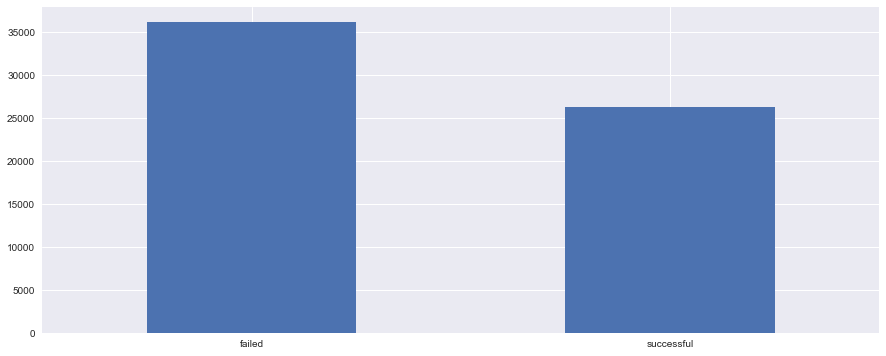

In [11]:
df_projects['state_end'].value_counts().plot(kind='bar')
plt.xticks(rotation='horizontal')

In [12]:
# https://www.kickstarter.com/spotlight?ref=faq_creator_spotlightwhat
# 'spotlight_end' basicaly means 'is_successfull'
# proof:
df_projects[(df_projects['spotlight_end']==True)].equals(df_projects[df_projects['state_end']=='successful'])

True

### Goal

In [13]:
df_projects['usd_goal'] = df_projects.apply(lambda x: int(x['goal']*x['static_usd_rate_end']), axis=1)

In [14]:
df_projects['usd_goal'].describe()

count    6.250700e+04
mean     5.782864e+04
std      1.266027e+06
min      0.000000e+00
25%      2.157500e+03
50%      6.324000e+03
75%      2.000000e+04
max      1.059990e+08
Name: usd_goal, dtype: float64

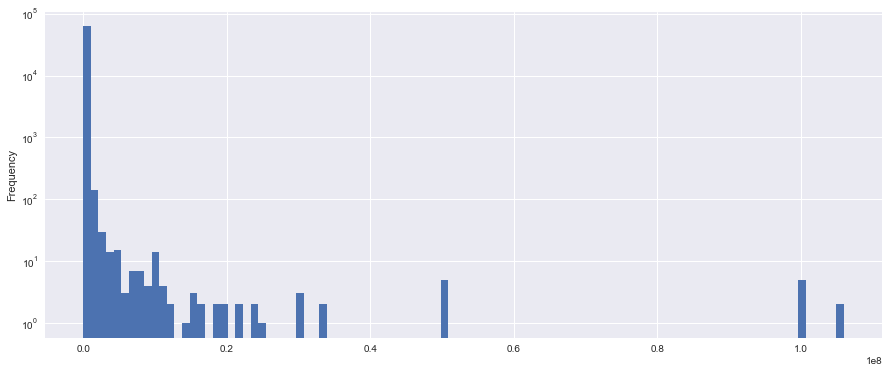

In [15]:
df_projects['usd_goal'].plot(kind='hist', bins=100)
plt.yscale('log')

(0, 100000)

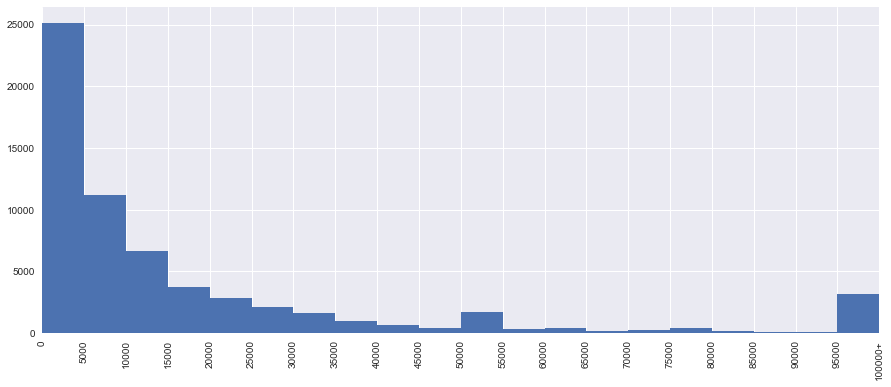

In [16]:
bins = np.arange(0,100500,5000)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects['usd_goal'], bins[0], bins[-1]), bins=bins, )

labels = [str(x) for x in np.arange(0,100500,5000)]
labels[-1] = labels[-1] + '+'

plt.xticks(np.arange(0,100500,5000), labels, rotation='vertical')
plt.xlim([0, 100000])

In [17]:
df_projects[df_projects['usd_goal'] < 100]['usd_goal'].value_counts().head()

1     83
50    67
10    38
20    25
99    24
Name: usd_goal, dtype: int64

In [18]:
len(df_projects[df_projects['usd_goal'] < 100])

584

### Live pledged amount

In [19]:
df_projects['usd_pledged'].describe()

count    6.250700e+04
mean     8.712150e+03
std      8.449931e+04
min      0.000000e+00
25%      1.292517e+01
50%      3.800000e+02
75%      2.829355e+03
max      1.102400e+07
Name: usd_pledged, dtype: float64

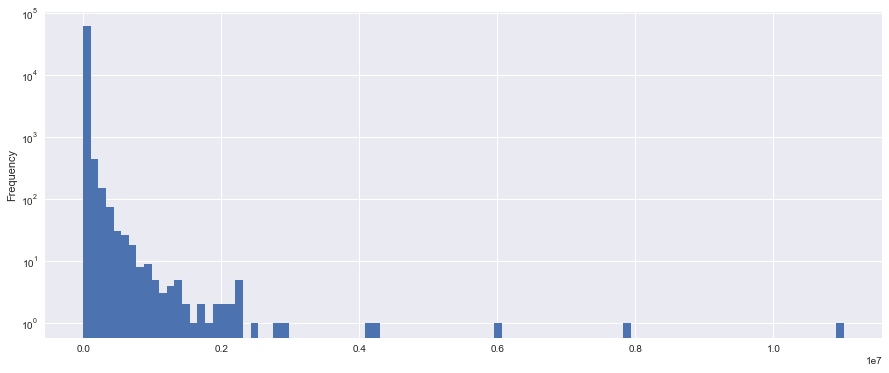

In [20]:
df_projects['usd_pledged'].plot(kind='hist', bins=100)
plt.yscale('log')

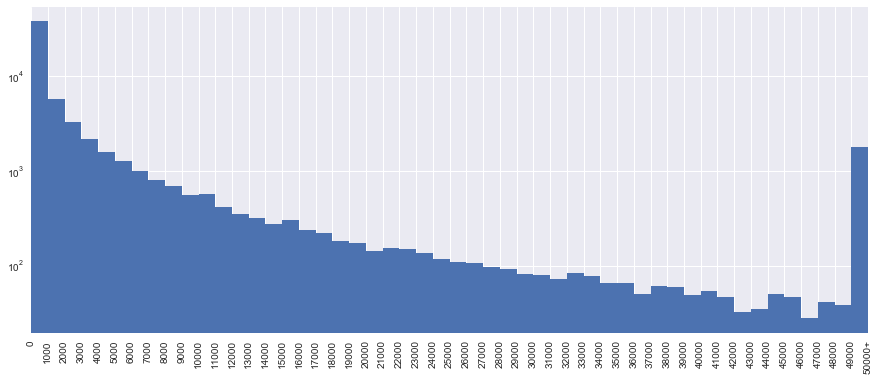

In [21]:
bins = np.arange(0,51000,1000)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects['usd_pledged'], bins[0], bins[-1]), bins=bins, )

labels = [str(x) for x in np.arange(0,51000,1000)]
labels[-1] = labels[-1] + '+'

plt.xticks(np.arange(0,51000,1000), labels, rotation='vertical')
plt.xlim([0, 50000])


plt.yscale('log')

#### How many projects have already been successful during first scraping

In [22]:
(df_projects['usd_pledged'] >= df_projects['usd_goal']).value_counts()

False    51110
True     11397
dtype: int64

### Pledged as a percentage of goal

In [23]:
df_projects['percentage_pledged_goal'] = 100*df_projects['pledged']/df_projects['goal']

In [24]:
df_projects['percentage_pledged_goal'].describe()

count    6.250700e+04
mean     2.767850e+02
std      1.523874e+04
min      0.000000e+00
25%      1.000000e-01
50%      9.631579e+00
75%      6.601000e+01
max      3.156867e+06
Name: percentage_pledged_goal, dtype: float64

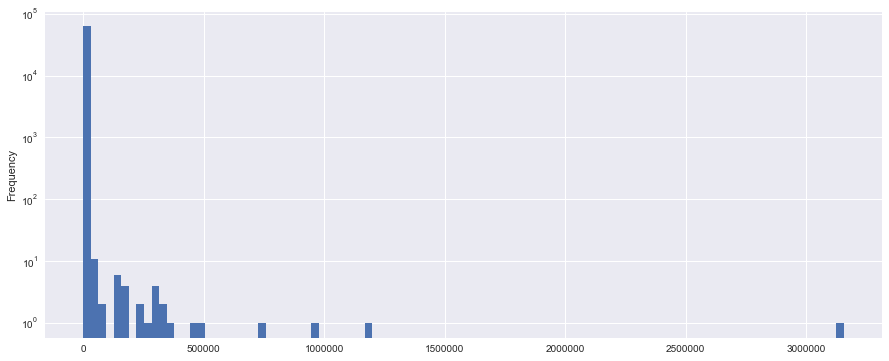

In [25]:
df_projects['percentage_pledged_goal'].plot(kind='hist', bins=100)
plt.yscale('log')

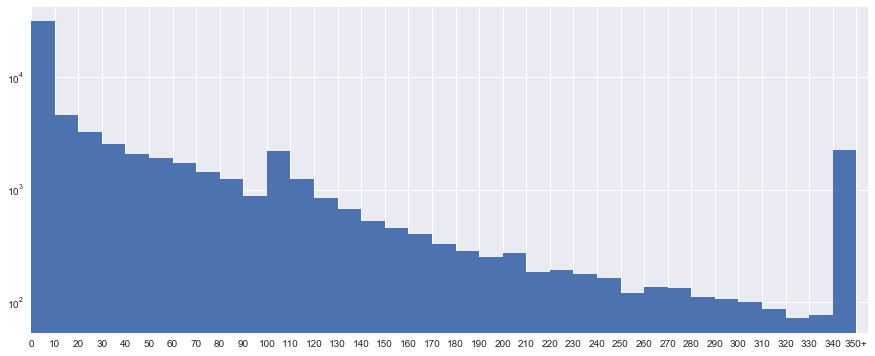

In [26]:
bins = np.arange(0,355,10)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects['percentage_pledged_goal'], bins[0], bins[-1]), bins=bins)

labels = [str(x) for x in np.arange(0,355,10)]
labels[-1] = labels[-1] + '+'

plt.xticks(np.arange(0,355,10), labels, rotation='horizontal')
plt.xlim([0, 355])


plt.yscale('log')

### Final pledged amount

In [27]:
df_projects['usd_pledged_end'].describe()

count    6.250700e+04
mean     1.538389e+04
std      1.287409e+05
min      0.000000e+00
25%      3.171932e+01
50%      7.465327e+02
75%      5.710395e+03
max      1.277984e+07
Name: usd_pledged_end, dtype: float64

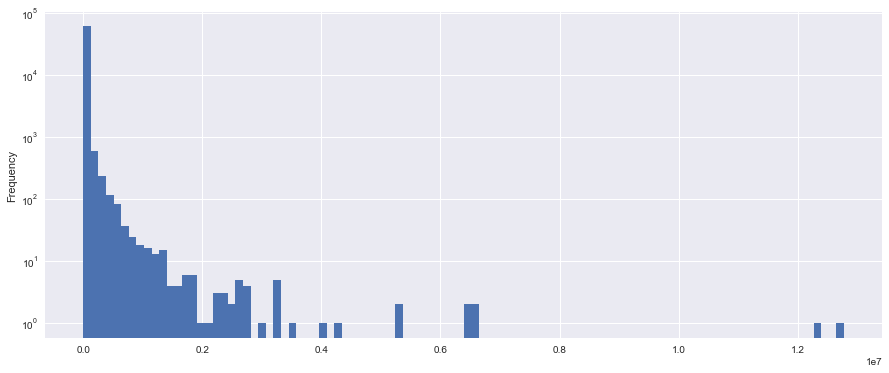

In [28]:
df_projects['usd_pledged_end'].plot(kind='hist', bins=100)
plt.yscale('log')

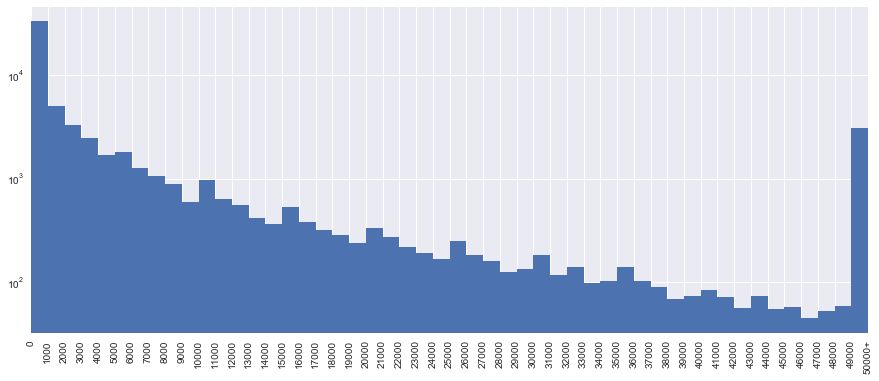

In [29]:
bins = np.arange(0,50500,1000)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects['usd_pledged_end'], bins[0], bins[-1]), bins=bins)

labels = [str(x) for x in np.arange(0,50500,1000)]
labels[-1] = labels[-1] + '+'

plt.xticks(np.arange(0,50500,1000), labels, rotation='vertical')
plt.xlim([0, 50000])


plt.yscale('log')

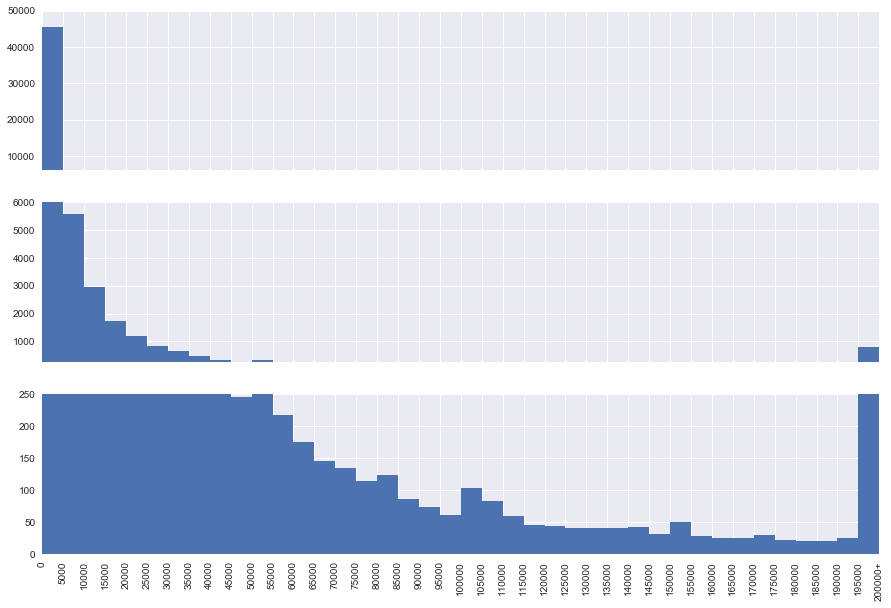

In [30]:
bins = np.arange(0,205000,5000)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.hist(np.clip(df_projects['usd_pledged_end'], bins[0], bins[-1]), bins=bins)
ax2.hist(np.clip(df_projects['usd_pledged_end'], bins[0], bins[-1]), bins=bins)
ax3.hist(np.clip(df_projects['usd_pledged_end'], bins[0], bins[-1]), bins=bins)

labels = [str(x) for x in np.arange(0,205000,5000)]
labels[-1] = labels[-1] + '+'

plt.xticks(np.arange(0,205000,5000), labels, rotation='vertical')
plt.xlim([0, 200000])


# zoom-in / limit the view to different portions of the data
ax1.set_ylim(6000, 50000)  # outliers only
ax2.set_ylim(250, 6000)  # most of the data
ax3.set_ylim(0, 250)  # most of the data

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax3.spines['top'].set_visible(False)

fig.set_size_inches(15, 10)

### Pledged end as a percentage of goal

In [31]:
df_projects['percentage_pledged_end_goal'] = 100*df_projects['pledged_end']/df_projects['goal']
df_projects['percentage_pledged_end_goal'].describe()

count    6.250700e+04
mean     6.298421e+02
std      4.267045e+04
min      0.000000e+00
25%      4.000000e-01
50%      1.920000e+01
75%      1.142000e+02
max      6.876410e+06
Name: percentage_pledged_end_goal, dtype: float64

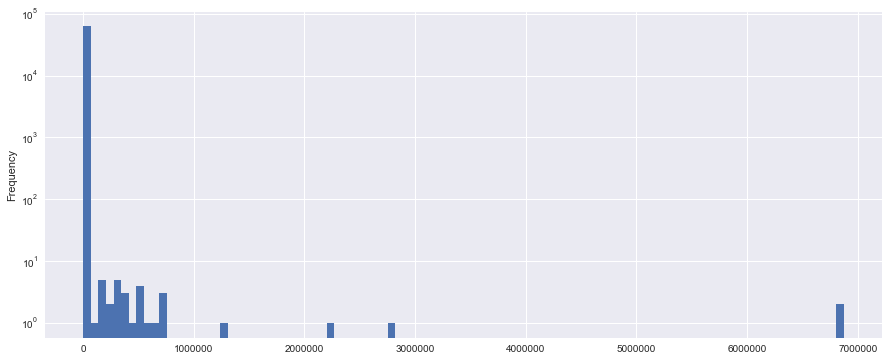

In [32]:
df_projects['percentage_pledged_end_goal'].plot(kind='hist', bins=100)
plt.yscale('log')

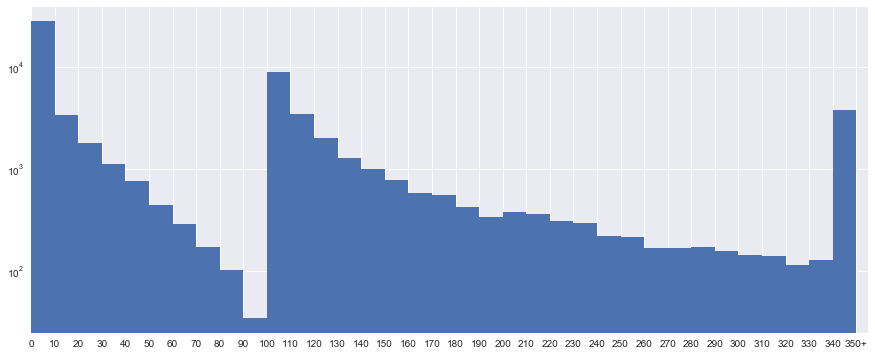

In [33]:
bins = np.arange(0,355,10)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects['percentage_pledged_end_goal'], bins[0], bins[-1]), bins=bins)

labels = [str(x) for x in np.arange(0,355,10)]
labels[-1] = labels[-1] + '+'

plt.xticks(np.arange(0,355,10), labels, rotation='horizontal')
plt.xlim([0, 355])


plt.yscale('log')

(-20, 370)

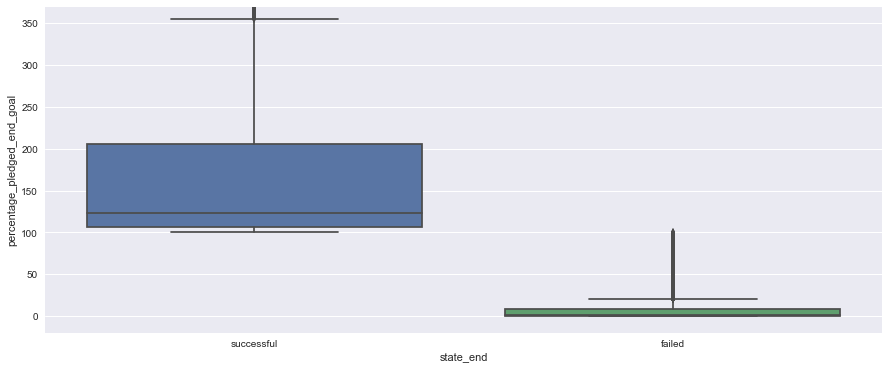

In [34]:
sns.boxplot(data=df_projects, x='state_end', y='percentage_pledged_end_goal')
#plt.yscale('log')
plt.ylim([-20, 370])

#### Pledged end as a percentage of goal (successful)

In [35]:
df_projects[df_projects['state_end'] == 'successful']['percentage_pledged_end_goal'].describe()

count    2.632900e+04
mean     1.484864e+03
std      6.573787e+04
min      1.000000e+02
25%      1.059091e+02
50%      1.230769e+02
75%      2.057800e+02
max      6.876410e+06
Name: percentage_pledged_end_goal, dtype: float64

In [36]:
df_projects[df_projects['state_end'] == 'successful'].sort_values(by=['percentage_pledged_end_goal'], ascending=False)[['name', 'usd_goal', 'usd_pledged_end']].head(10)

,name,usd_goal,usd_pledged_end
37100,Re-covering with Friends,1,68764.10
37101,Re-covering with Friends,1,68764.10
4437,CLOCKWRIGHT: Large-Scale Analogue Time Machines,1,27588.23
34741,THE 'mi8' RISES | The Best Wireless Duo Stereo...,1,22603.00
375,"Multi-Purpose, All-Occasion Greeting Cards",2,25150.30
33675,Dice Set Felt Coasters,1,7548.00
42050,Big Something Tumbleweed Pre-Order,1,7529.00
42051,Big Something Tumbleweed Pre-Order,1,7529.00
44630,The Horror and Sci-Fi Movie Prop Book,1,6435.00
48649,HAIR TO THE THRONE,1,5607.00


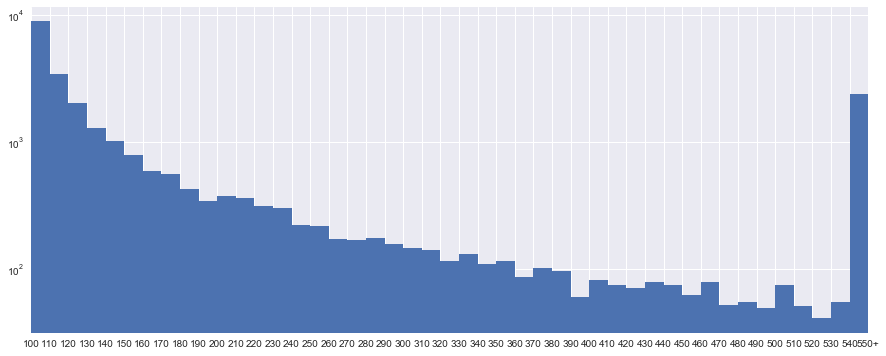

In [37]:
bins = np.arange(0,560,10)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects[df_projects['state_end'] == 'successful']['percentage_pledged_end_goal'], bins[0], bins[-1]), bins=bins)

labels = [str(x) for x in np.arange(0,560,10)]
labels[-1] = labels[-1] + '+'

plt.xticks(np.arange(0,560,10), labels, rotation='horizontal')
plt.xlim([100, 550])

plt.yscale('log')

#### Pledged end as a percentage of goal (failed)

In [38]:
df_projects[df_projects['state_end'] == 'failed']['percentage_pledged_end_goal'].describe()

count    36178.000000
mean         7.588828
std         14.275313
min          0.000000
25%          0.013333
50%          0.883558
75%          8.000000
max         99.997417
Name: percentage_pledged_end_goal, dtype: float64

In [39]:
df_projects[(df_projects['state_end'] == 'failed') & (df_projects['percentage_pledged_end_goal'] > 95)][['name', 'usd_goal', 'usd_pledged_end']]

,name,usd_goal,usd_pledged_end
1450,Spooky Nation - Changing The World One Shirt A...,21321,20516.000000
5794,1 2 3 4 I declare a Pizza-War,37,36.379161
6453,Pyrex & Shookz - The Resume,711,710.898450
7260,The 5th Annual 90 Square Arts Festival,12000,11999.690000
13404,2016-2017 Fireball Newsflash Crosswords,8000,7904.000000
18852,"Spün - Calorie-Counting, Nutrition Tracking Ut...",150000,144453.000000
25699,18 Customizable Real Physical Buttons on a Fli...,22463,21493.586202
30484,Rainbow Illusion Playing Cards Version 2,6000,5932.230000
31398,Community Gardens in NYC: A Legal Primer,800,770.000000
38416,Remotsy | WiFi Remote for Alexa and SmartThings,15000,14470.000000


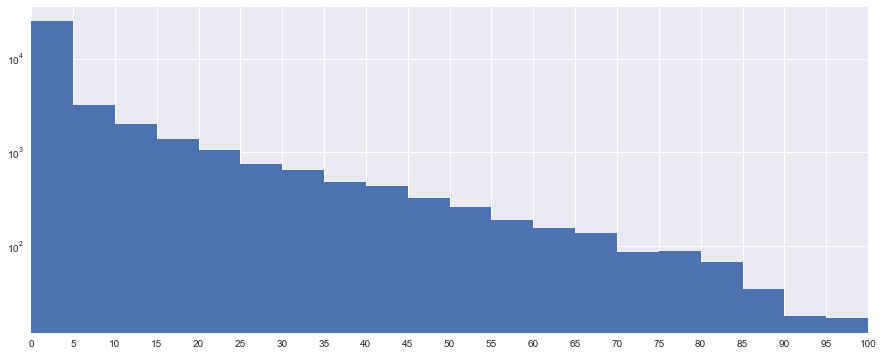

In [40]:
bins = np.arange(0,105,5)
fig, ax = plt.subplots()
_, bins, patches = plt.hist(np.clip(df_projects[df_projects['state_end'] == 'failed']['percentage_pledged_end_goal'], bins[0], bins[-1]), bins=bins)

plt.xticks(np.arange(0,105,5))
plt.xlim([0, 100])

plt.yscale('log')

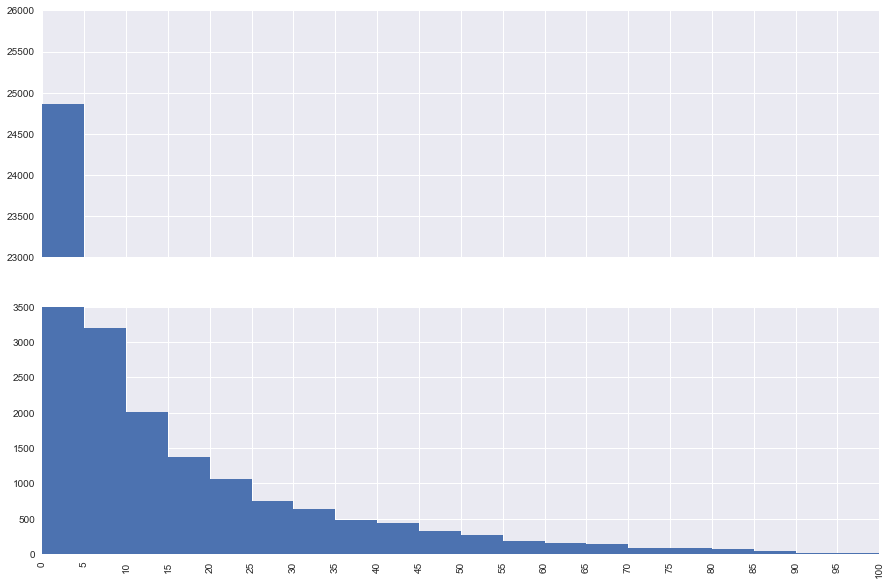

In [41]:
bins = np.arange(0,105,5)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(np.clip(df_projects[df_projects['state_end'] == 'failed']['percentage_pledged_end_goal'], bins[0], bins[-1]), bins=bins)
ax2.hist(np.clip(df_projects[df_projects['state_end'] == 'failed']['percentage_pledged_end_goal'], bins[0], bins[-1]), bins=bins)

plt.xticks(bins, rotation='vertical')
plt.xlim([0, 100])

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(23000, 26000)  # outliers only
ax2.set_ylim(0, 3500)  # most of the data

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

fig.set_size_inches(15, 10)

### Campaign duration

In [42]:
df_projects['days_duration'].describe()

count    62507.000000
mean        36.467884
std         12.363244
min          2.000000
25%         30.000000
50%         30.000000
75%         45.000000
max         60.000000
Name: days_duration, dtype: float64

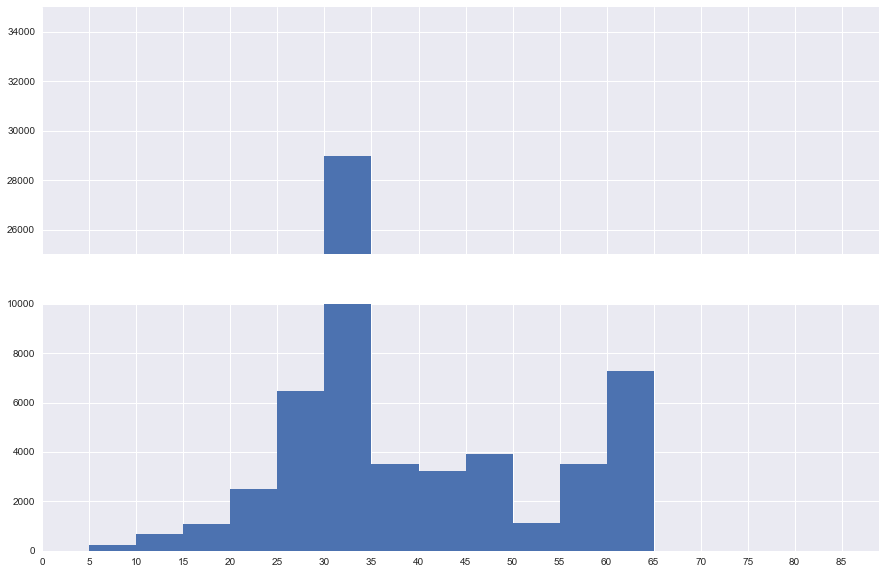

In [43]:
bins = np.arange(0,100,5)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(np.clip(df_projects['days_duration'], bins[0], bins[-1]), bins=bins)
ax2.hist(np.clip(df_projects['days_duration'], bins[0], bins[-1]), bins=bins)

plt.xticks(bins)
plt.xlim([0, 89])

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(25000, 35000)  # outliers only
ax2.set_ylim(0, 10000)  # most of the data

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

fig.set_size_inches(15, 10)

In [44]:
df_projects[df_projects['days_duration'] <= 15]['days_duration'].value_counts()

15    428
14    349
10    137
7     113
13    102
12     55
11     44
9      38
6      30
8      23
5      22
4       2
3       2
2       1
Name: days_duration, dtype: int64

### Days running

In [45]:
df_projects['days_running'].describe()

count    62507.000000
mean        17.910874
std         12.863839
min          0.000000
25%          8.000000
50%         16.000000
75%         25.000000
max         60.000000
Name: days_running, dtype: float64

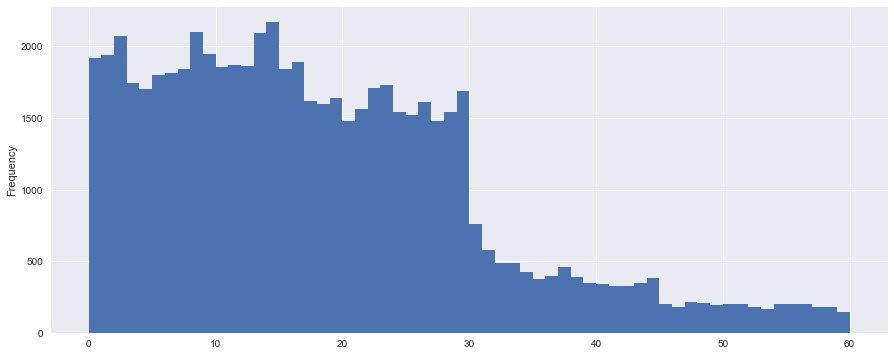

In [46]:
df_projects['days_running'].plot(kind='hist', bins=60)

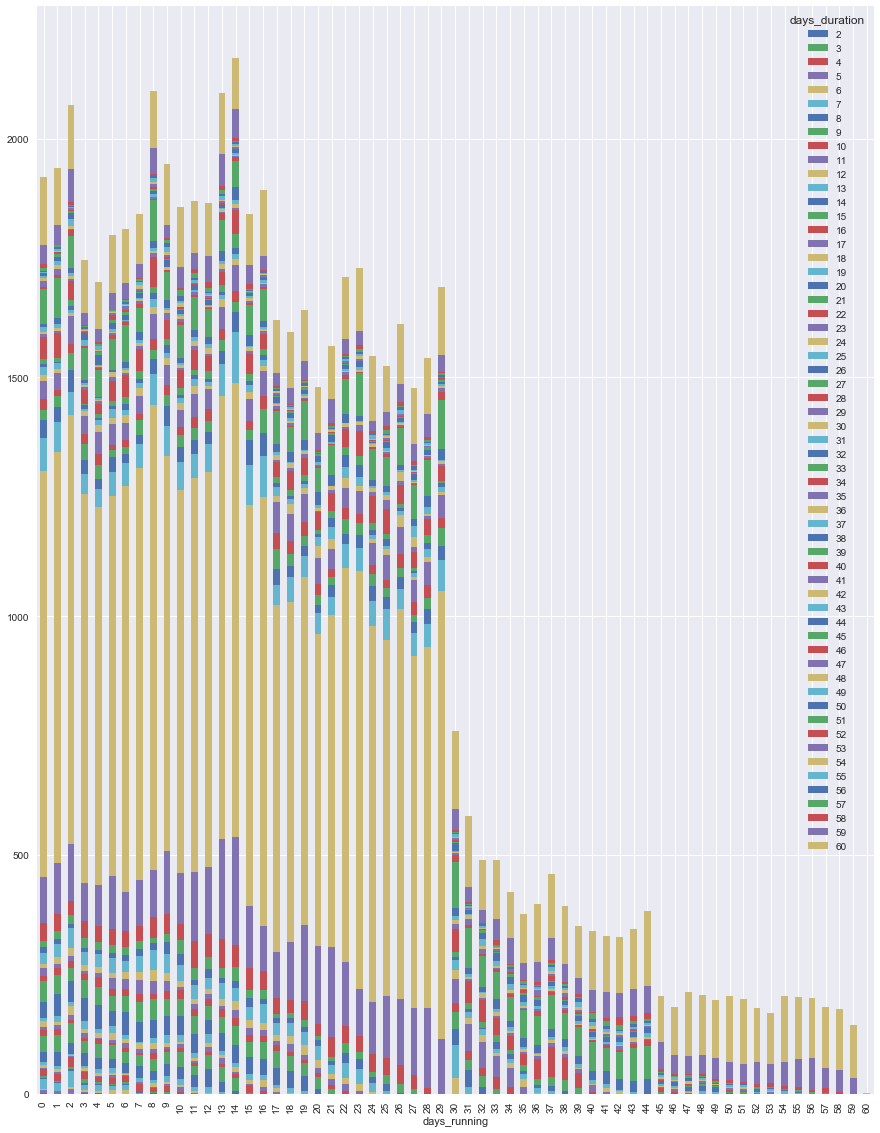

In [47]:
pd.crosstab(index=df_projects['days_running'], columns=df_projects['days_duration']).plot.bar(stacked=True, figsize=(15, 20))

### Days running as a percentage of campaign duration

In [48]:
df_projects['percentage_running_duration'] = (100*df_projects['days_running']/df_projects['days_duration']).round(0).astype('int64')
df_projects['percentage_running_duration'].describe()

count    62507.000000
mean        48.806470
std         28.965469
min          0.000000
25%         24.000000
50%         48.000000
75%         73.000000
max        100.000000
Name: percentage_running_duration, dtype: float64

In [61]:
df_projects['percentage_running_duration'] = df_projects['percentage_running_duration'].apply(lambda x: int(5*round(float(x)/5)))

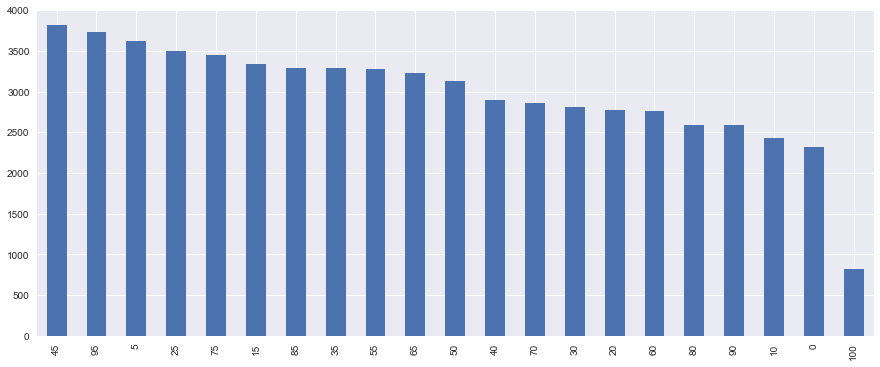

In [62]:
df_projects['percentage_running_duration'].value_counts().plot.bar()

## Analysis of pledged amount grouped by days running as a percentage of campaign

### using mean

(0, 223443.70050863095)

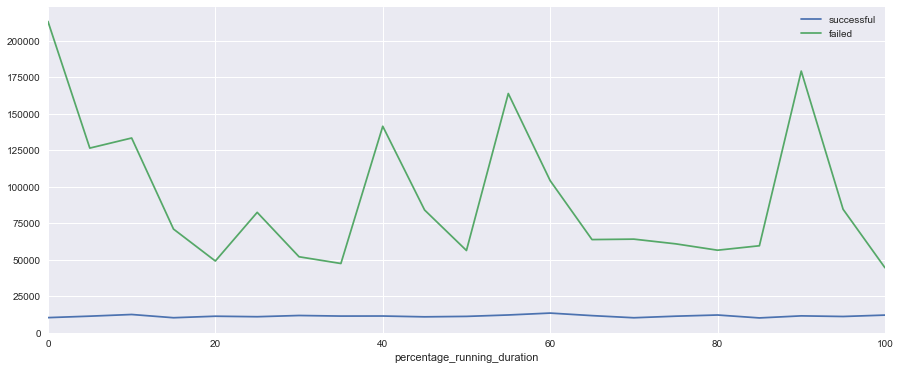

In [76]:
x_mean_s = df_projects[df_projects['state_end'] == 'successful'].groupby('percentage_running_duration').mean()
x_mean_f = df_projects[df_projects['state_end'] == 'failed'].groupby('percentage_running_duration').mean()
x_mean_s['usd_goal'].plot(kind='line', label='successful', legend=True)
x_mean_f['usd_goal'].plot(kind='line', label='failed', legend=True)

plt.ylim(ymin=0)

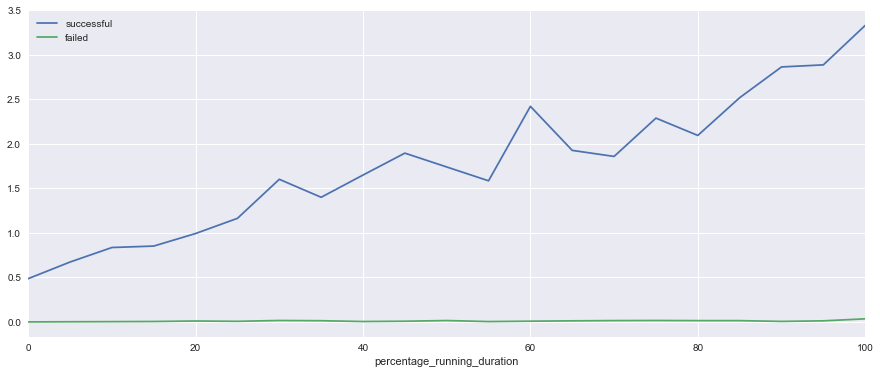

In [77]:
(x_mean_s['usd_pledged'] / x_mean_s['usd_goal']).plot(kind='line', label='successful', legend=True)
(x_mean_f['usd_pledged'] / x_mean_f['usd_goal']).plot(kind='line', label='failed', legend=True)

### using sum

(0, 332098652.85000002)

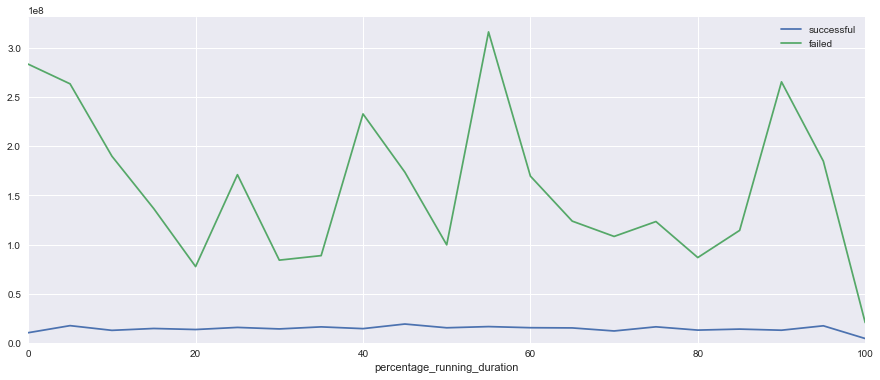

In [78]:
# 0 and 100 have shorter intervals therefore sum is lower
x_sum_s = df_projects[df_projects['state_end'] == 'successful'].groupby('percentage_running_duration').sum()
x_sum_f = df_projects[df_projects['state_end'] == 'failed'].groupby('percentage_running_duration').sum()
x_sum_s['usd_goal'].plot(kind='line', label='successful', legend=True)
x_sum_f['usd_goal'].plot(kind='line', label='failed', legend=True)

plt.ylim(ymin=0)

(0, 3.4965081641221083)

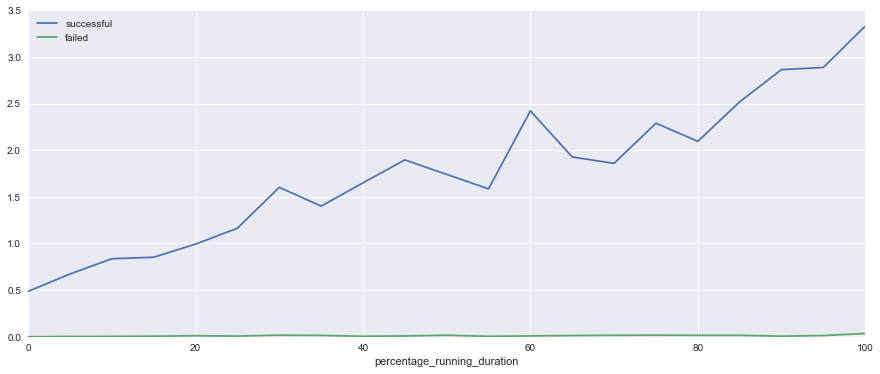

In [79]:
(x_sum_s['usd_pledged'] / x_sum_s['usd_goal']).plot(kind='line', label='successful', legend=True)
(x_sum_f['usd_pledged'] / x_sum_f['usd_goal']).plot(kind='line', label='failed', legend=True)
plt.ylim(ymin=0)

### using median

(0, 10300.0)

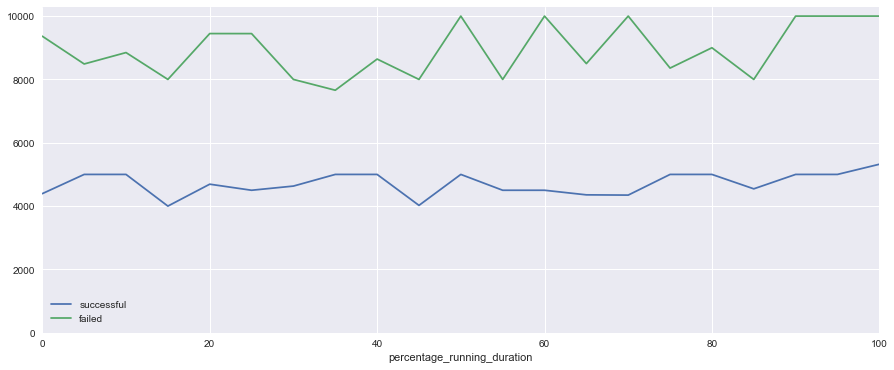

In [80]:
# 0 and 100 have shorter intervals therefore sum is lower
x_median_s = df_projects[df_projects['state_end'] == 'successful'].groupby('percentage_running_duration').median()
x_median_f = df_projects[df_projects['state_end'] == 'failed'].groupby('percentage_running_duration').median()
x_median_s['usd_goal'].plot(kind='line', label='successful', legend=True)
x_median_f['usd_goal'].plot(kind='line', label='failed', legend=True)

plt.ylim(ymin=0)

(0, 1.5391843638413831)

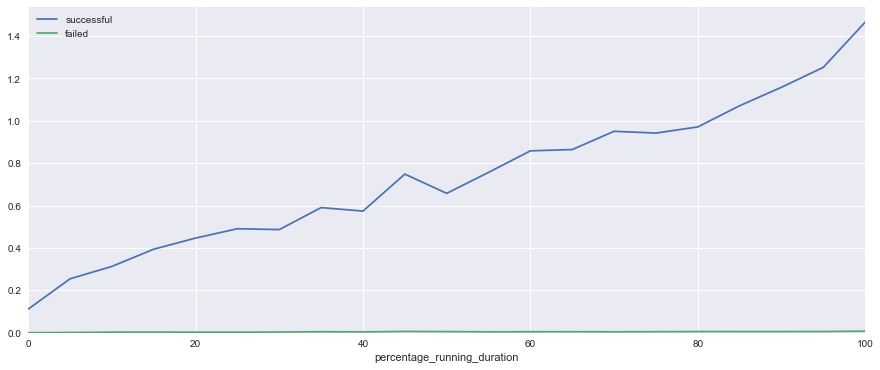

In [81]:
(x_median_s['usd_pledged'] / x_median_s['usd_goal']).plot(kind='line', label='successful', legend=True)
(x_median_f['usd_pledged'] / x_median_f['usd_goal']).plot(kind='line', label='failed', legend=True)
plt.ylim(ymin=0)

In [108]:
list(df_projects.select_dtypes([np.number]))

['backers_count',
 'backers_count_end',
 'category_position',
 'category_position_end',
 'created_at',
 'deadline_end',
 'goal',
 'id',
 'launched_at',
 'pledged',
 'pledged_end',
 'scraped_at',
 'state_changed_at',
 'state_changed_at_end',
 'static_usd_rate',
 'static_usd_rate_end',
 'usd_pledged',
 'usd_pledged_end',
 'days_duration',
 'days_preparation',
 'days_running',
 'days_remaining',
 'usd_goal',
 'percentage_pledged_goal',
 'percentage_pledged_end_goal',
 'percentage_running_duration']

In [109]:
cols=[
    'backers_count',
    'backers_count_end',
    'days_duration',
    'days_preparation',
    'days_running',
    'days_remaining',
    'usd_goal',
    'usd_pledged',
    'usd_pledged_end',
    'category_position',
    'category_position_end',
    'percentage_pledged_goal',
    'percentage_pledged_end_goal',
    'percentage_running_duration'
    ]

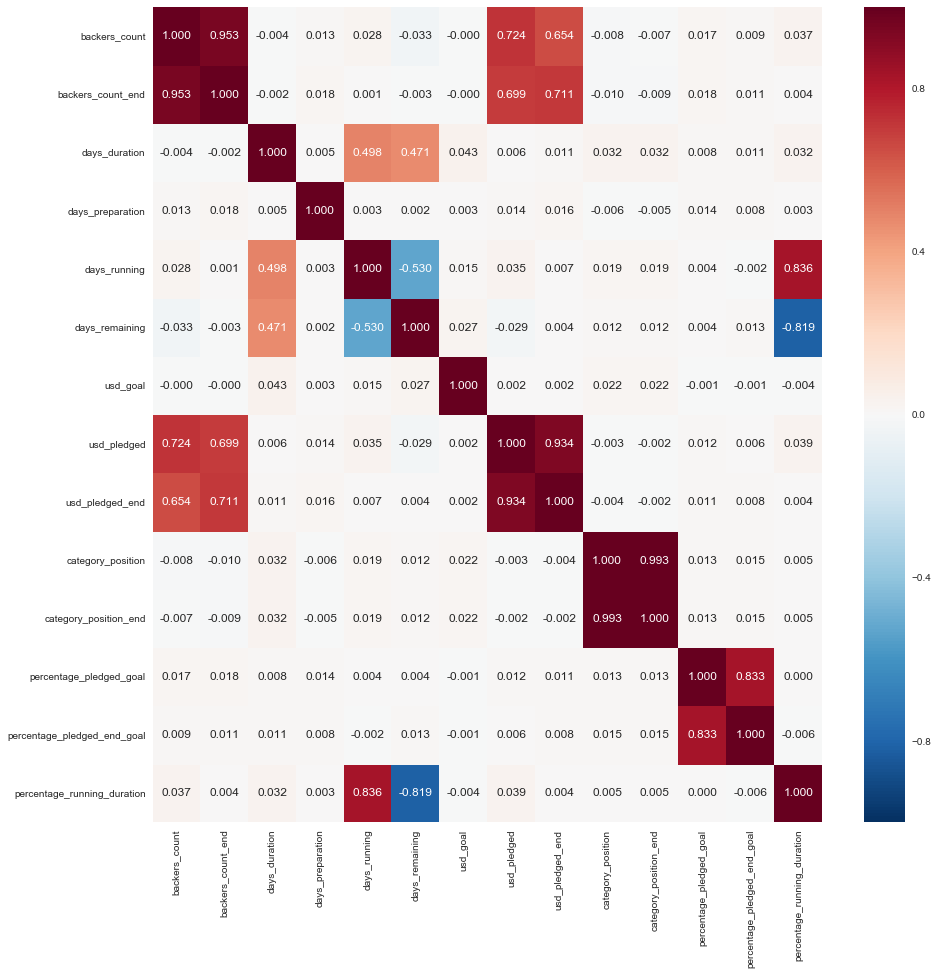

In [114]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_projects[cols].corr(), ax=ax, annot=True, fmt=".3f")
#print_corr_heatmap(cols)

# My legacy

### Numeric variables

In [5]:
df_projects.describe()

,backers_count,backers_count_end,category_position,category_position_end,created_at,deadline_end,goal,id,launched_at,pledged,pledged_end,scraped_at,state_changed_at,state_changed_at_end,static_usd_rate,static_usd_rate_end,usd_pledged,usd_pledged_end
count,65038.000000,65038.000000,65038.000000,65038.000000,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,65038.000000,65038.000000,6.503800e+04,6.503800e+04
mean,93.181801,159.475753,6.396199,6.404963,1.467838e+09,1.475652e+09,7.045290e+04,1.073002e+09,1.472475e+09,9.706526e+03,1.708096e+04,1.474044e+09,1.472475e+09,1.475610e+09,0.994714,0.994716,8.547335e+03,1.502729e+04
std,924.687360,1272.604621,4.300691,4.306053,2.076627e+07,1.672703e+07,1.474647e+06,6.193397e+08,1.677238e+07,8.741706e+04,1.353804e+05,1.670745e+07,1.677239e+07,1.672708e+07,0.220278,0.220277,8.302131e+04,1.264395e+05
min,0.000000,0.000000,1.000000,1.000000,1.266343e+09,1.446392e+09,1.000000e+00,1.852000e+04,1.441143e+09,0.000000e+00,0.000000e+00,1.446391e+09,1.441143e+09,1.446392e+09,0.009143,0.009143,0.000000e+00,0.000000e+00
25%,1.000000,2.000000,3.000000,3.000000,1.455334e+09,1.462058e+09,2.400000e+03,5.376639e+08,1.458759e+09,1.200000e+01,3.100000e+01,1.460686e+09,1.458759e+09,1.462036e+09,1.000000,1.000000,1.200000e+01,3.093878e+01
50%,7.000000,13.000000,5.000000,5.000000,1.467867e+09,1.475073e+09,7.000000e+03,1.072097e+09,1.471891e+09,3.860000e+02,7.510000e+02,1.473905e+09,1.471891e+09,1.474991e+09,1.000000,1.000000,3.700000e+02,7.187814e+02
75%,41.000000,75.000000,8.000000,8.000000,1.483904e+09,1.489795e+09,2.000000e+04,1.606240e+09,1.486687e+09,2.982000e+03,5.891750e+03,1.487201e+09,1.486687e+09,1.489787e+09,1.000000,1.000000,2.778168e+03,5.563885e+03
max,145232.000000,154926.000000,19.000000,19.000000,1.505473e+09,1.511283e+09,1.000000e+08,2.147422e+09,1.505523e+09,1.102400e+07,1.277984e+07,1.505514e+09,1.505523e+09,1.508084e+09,1.557361,1.557361,1.102400e+07,1.277984e+07


In [7]:
selected_cols = ['backers_count', 'goal', 'pledged', 'usd_pledged', 'backers_count_end', 'pledged_end', 'usd_pledged_end', 'state_end']
df_projects[selected_cols].head()

,backers_count,goal,pledged,usd_pledged,backers_count_end,pledged_end,usd_pledged_end,state_end
0,22,8000.0,1272.0,1272.0,87,8441.0,8441.0,successful
1,0,500.0,0.0,0.0,0,0.0,0.0,failed
2,1,25000.0,50.0,50.0,3,70.0,70.0,failed
3,1,600.0,30.0,30.0,22,904.0,904.0,successful
4,5,600.0,306.0,306.0,22,904.0,904.0,successful


In [8]:
df_projects[selected_cols].describe()

,backers_count,goal,pledged,usd_pledged,backers_count_end,pledged_end,usd_pledged_end
count,65038.000000,6.503800e+04,6.503800e+04,6.503800e+04,65038.000000,6.503800e+04,6.503800e+04
mean,93.181801,7.045290e+04,9.706526e+03,8.547335e+03,159.475753,1.708096e+04,1.502729e+04
std,924.687360,1.474647e+06,8.741706e+04,8.302131e+04,1272.604621,1.353804e+05,1.264395e+05
min,0.000000,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,1.000000,2.400000e+03,1.200000e+01,1.200000e+01,2.000000,3.100000e+01,3.093878e+01
50%,7.000000,7.000000e+03,3.860000e+02,3.700000e+02,13.000000,7.510000e+02,7.187814e+02
75%,41.000000,2.000000e+04,2.982000e+03,2.778168e+03,75.000000,5.891750e+03,5.563885e+03
max,145232.000000,1.000000e+08,1.102400e+07,1.102400e+07,154926.000000,1.277984e+07,1.277984e+07


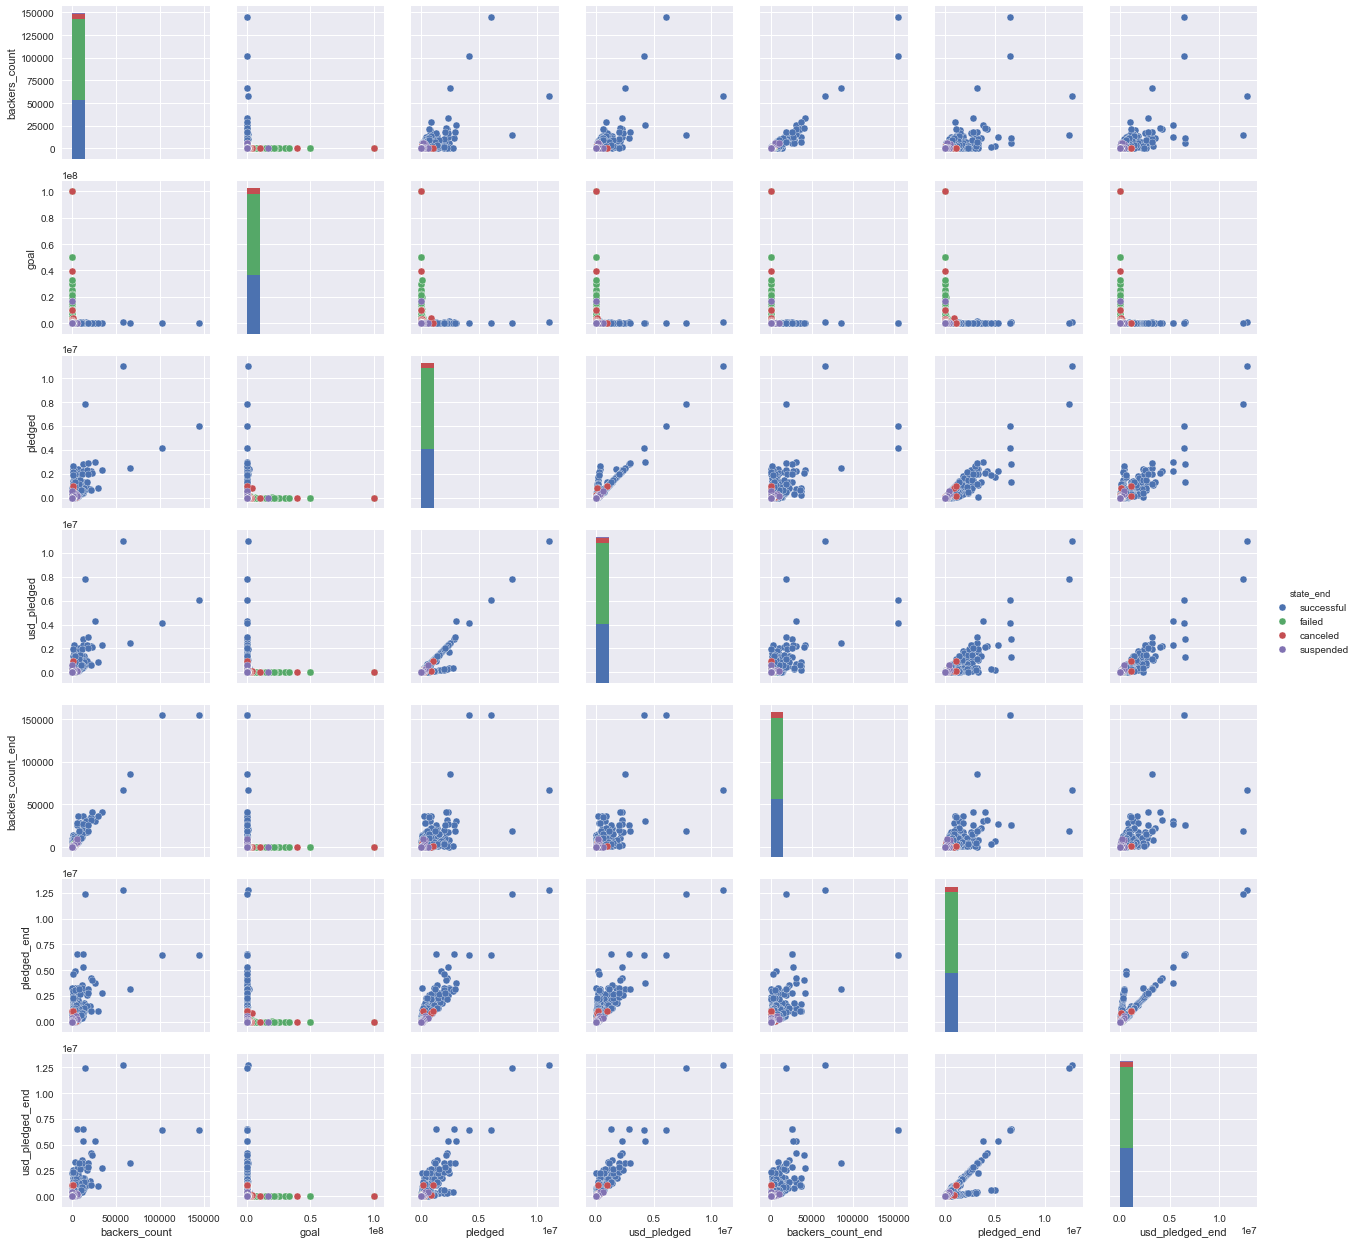

In [9]:
figure = sns.pairplot(df_projects[selected_cols], hue='state_end')

In [10]:
figure.savefig('figure.png', format='png', dpi=200)

#### backers_count

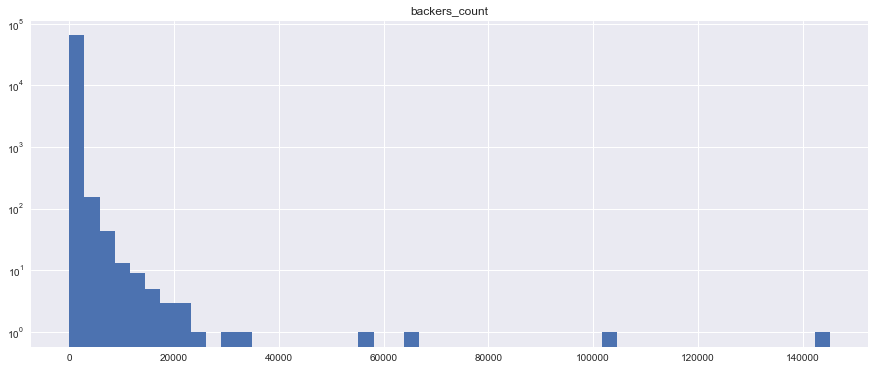

In [11]:
df_projects.hist(column='backers_count', bins=50)
plt.yscale('log')

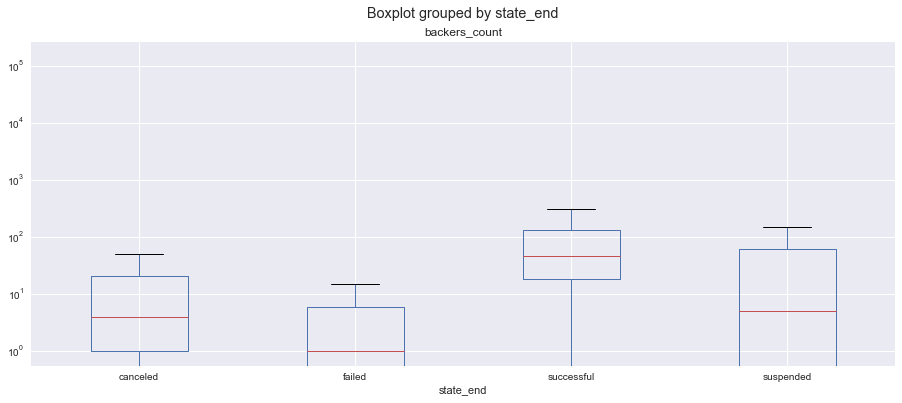

In [12]:
bp = df_projects.boxplot(column='backers_count', by='state_end')
plt.yscale('log')

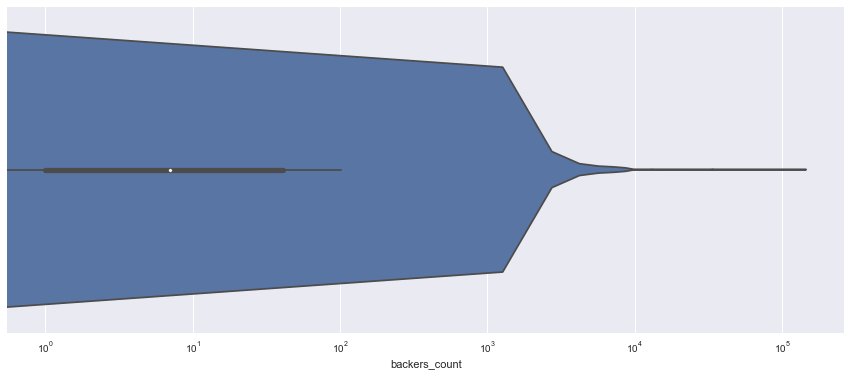

In [13]:
sns.violinplot(df_projects['backers_count'], width=20)
plt.xscale('log')

#### goal

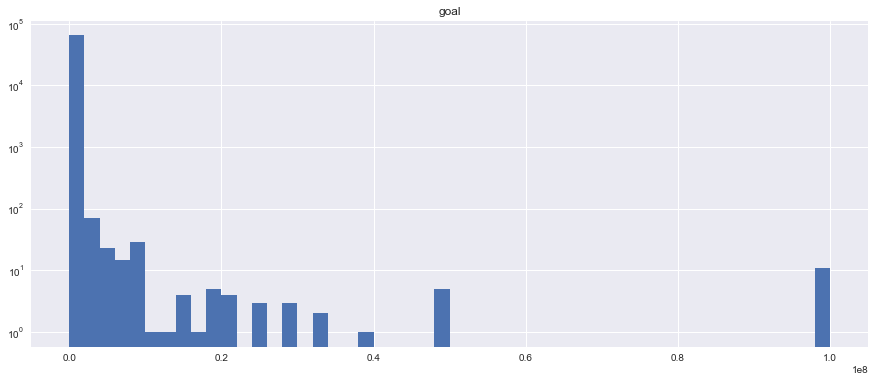

In [14]:
df_projects.hist(column='goal', bins=50)
plt.yscale('log')

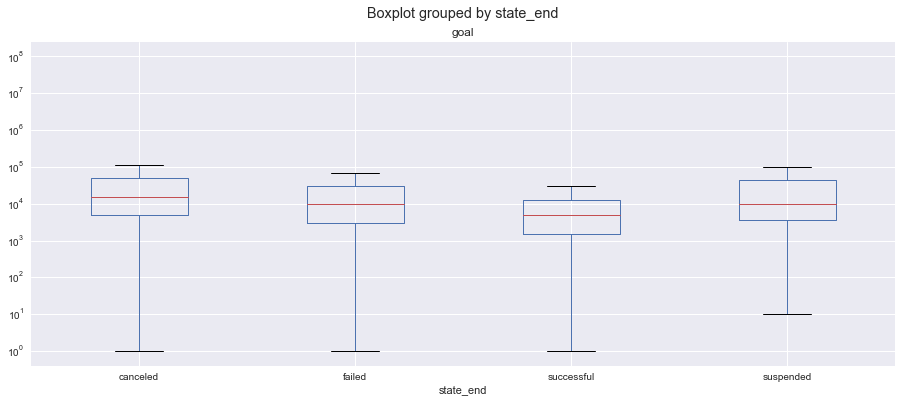

In [15]:
bp = df_projects.boxplot(column='goal', by='state_end')
plt.yscale('log')

#### pledged

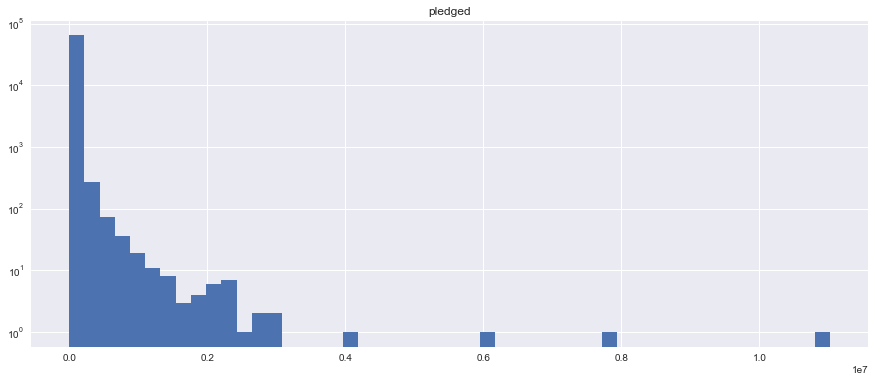

In [16]:
df_projects.hist(column='pledged', bins=50)
plt.yscale('log')

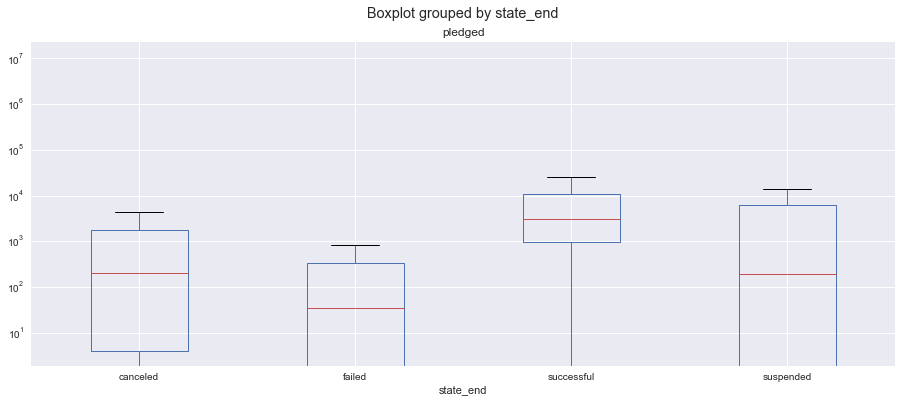

In [17]:
bp = df_projects.boxplot(column='pledged', by='state_end')
plt.yscale('log')

#### usd_pledged

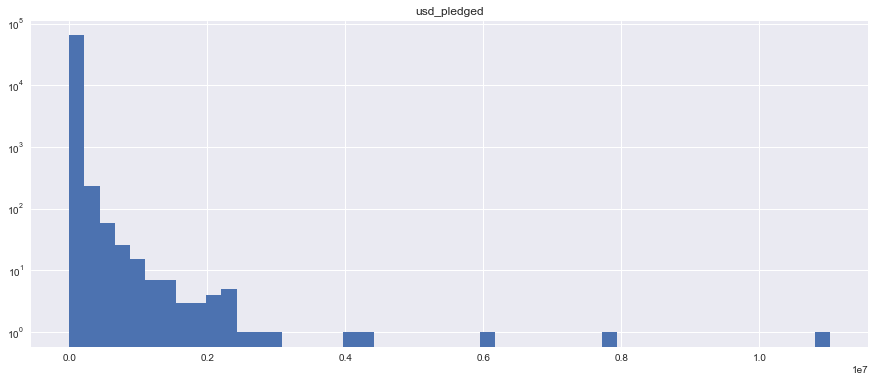

In [18]:
df_projects.hist(column='usd_pledged', bins=50)
plt.yscale('log')

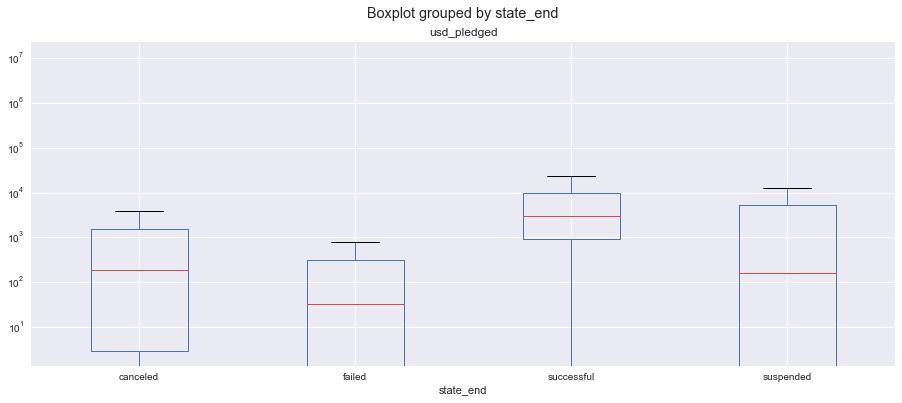

In [19]:
bp = df_projects.boxplot(column='usd_pledged', by='state_end')
plt.yscale('log')

#### backers_count_end

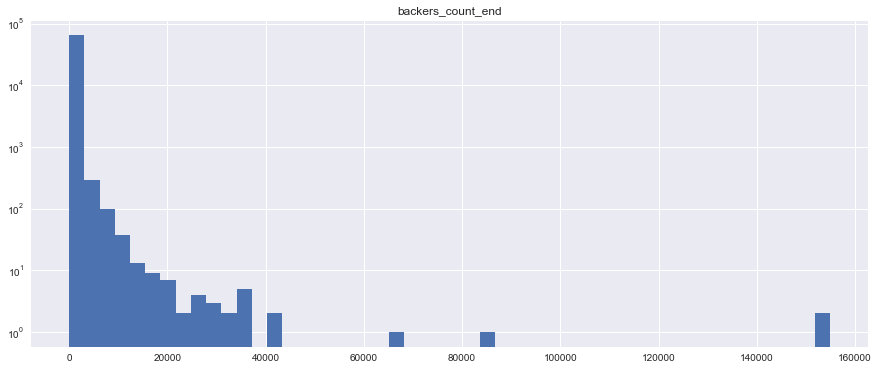

In [20]:
df_projects.hist(column='backers_count_end', bins=50)
plt.yscale('log')

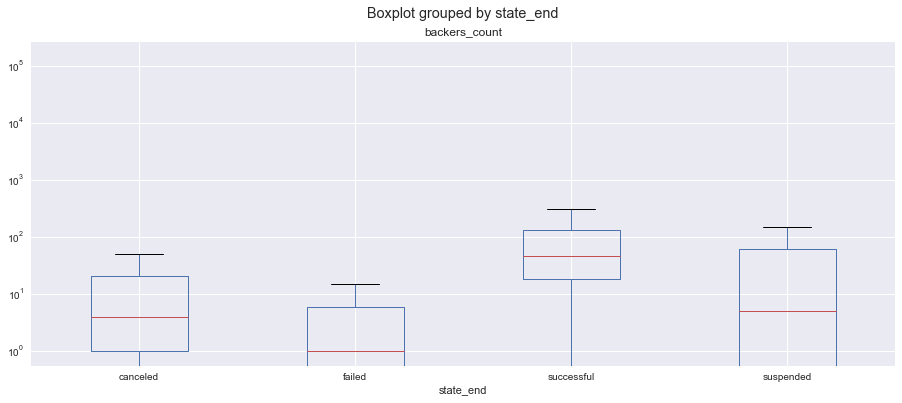

In [21]:
bp = df_projects.boxplot(column='backers_count', by='state_end')
plt.yscale('log')

#### pledged_end

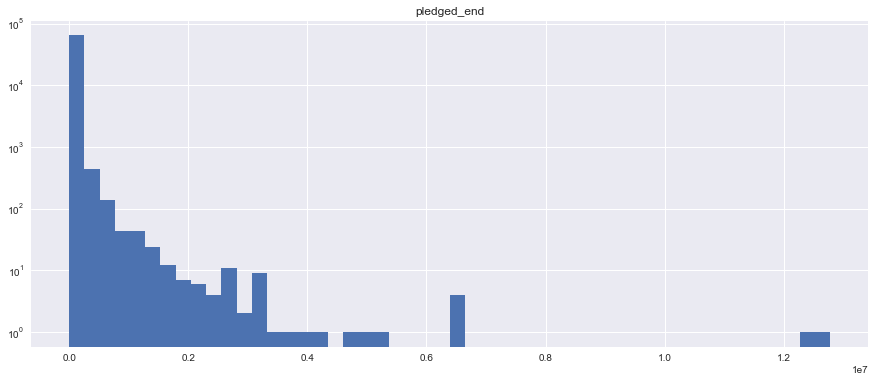

In [22]:
df_projects.hist(column='pledged_end', bins=50)
plt.yscale('log')

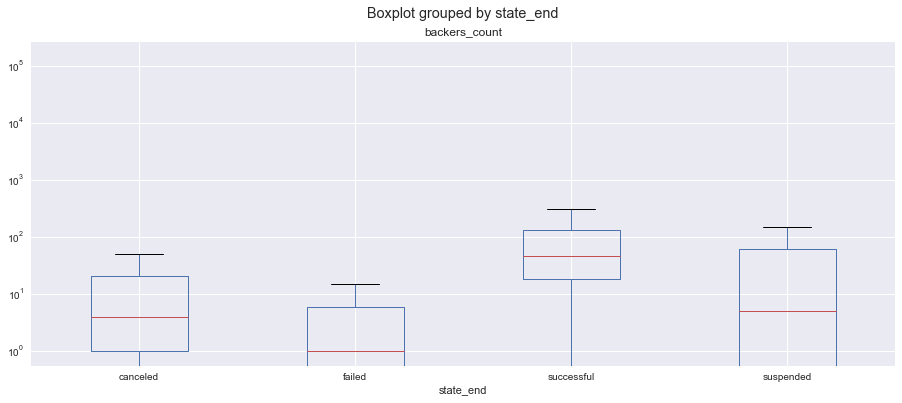

In [23]:
bp = df_projects.boxplot(column='backers_count', by='state_end')
plt.yscale('log')

#### usd_pledged_end

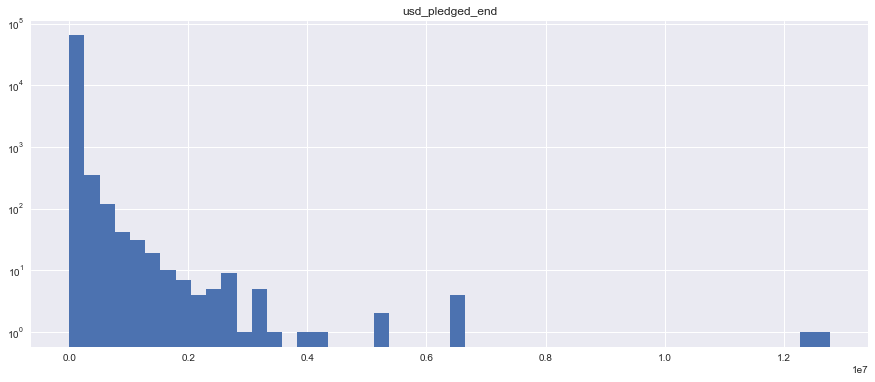

In [24]:
df_projects.hist(column='usd_pledged_end', bins=50)
plt.yscale('log')

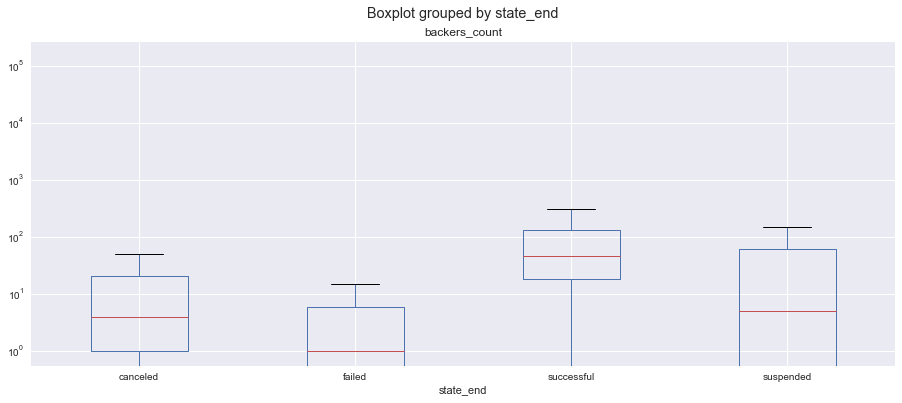

In [25]:
bp = df_projects.boxplot(column='backers_count', by='state_end')
plt.yscale('log')

In [82]:
def print_corr_heatmap(cols):
    corr = df_projects[cols].corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        ax = sns.heatmap(corr, mask=mask, annot=True, square=True)

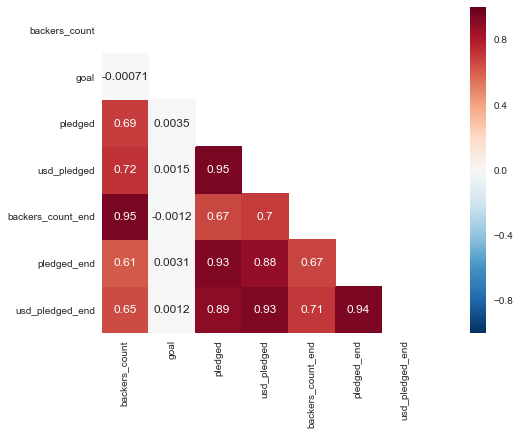

In [27]:
print_corr_heatmap(selected_cols)

All of seven variables have similar **long tale distribution**. Also pledged and usd_pledged equivalents are very similar which suggests that most of projects collected their money in USD. Let's look at categorical variables to find out.

### Categorical variables

In [28]:
df_projects = pd.read_csv('projects.csv', encoding='cp1252', index_col=0)

C:\Users\Patrik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
selected_cols = [
    'state_end',
    'currency_trailing_code',
    'disable_communication',
    'state',
    'spotlight',
    'disable_communication_end',
    'spotlight_end',
    'staff_pick',
    'staff_pick_end',
    'country',
    'currency',
    'currency_symbol'
]

In [30]:
df_projects[selected_cols].head()

,state_end,currency_trailing_code,disable_communication,state,spotlight,disable_communication_end,spotlight_end,staff_pick,staff_pick_end,country,currency,currency_symbol
0,successful,True,False,live,False,False,True,NaN,NaN,US,USD,$
1,failed,False,False,live,False,False,False,NaN,NaN,NL,EUR,€
2,failed,True,False,live,False,False,False,NaN,NaN,US,USD,$
3,successful,True,False,live,False,False,True,NaN,False,US,USD,$
4,successful,True,False,live,False,False,True,NaN,False,US,USD,$


In [31]:
def print_counts(cols):
    for col in cols:
        print('\n>>> '+col+':')
        print(df_projects[col].value_counts())

In [32]:
print_counts(selected_cols)


>>> state_end:
failed        36190
successful    26342
canceled       2380
suspended       126
Name: state_end, dtype: int64

>>> currency_trailing_code:
True     51119
False    13919
Name: currency_trailing_code, dtype: int64

>>> disable_communication:
False    65038
Name: disable_communication, dtype: int64

>>> state:
live    65038
Name: state, dtype: int64

>>> spotlight:
False    65038
Name: spotlight, dtype: int64

>>> disable_communication_end:
False    64912
True       126
Name: disable_communication_end, dtype: int64

>>> spotlight_end:
False    38696
True     26342
Name: spotlight_end, dtype: int64

>>> staff_pick:
False    52537
True      4966
Name: staff_pick, dtype: int64

>>> staff_pick_end:
False    55199
True      6150
Name: staff_pick_end, dtype: int64

>>> country:
US    43245
GB     6757
CA     3296
AU     1814
DE     1598
IT     1362
FR     1291
ES     1018
MX      854
NL      649
SE      569
CH      373
DK      330
BE      329
NZ      317
IE      265
AT      253


#### Dropping columns

In [33]:
# 'disable_communication' is always false
# 'state' is always live
# 'spotlight' is always false
# 'currency_symbol' carries the same information as currency and some values are not recognizable
remove_cols = ['disable_communication','state','spotlight','currency_symbol']
df_projects.drop(remove_cols, axis=1, inplace=True)

In [34]:
for col in remove_cols:
    selected_cols.remove(col)

In [35]:
print_counts(selected_cols[:-2])


>>> state_end:
failed        36190
successful    26342
canceled       2380
suspended       126
Name: state_end, dtype: int64

>>> currency_trailing_code:
True     51119
False    13919
Name: currency_trailing_code, dtype: int64

>>> disable_communication_end:
False    64912
True       126
Name: disable_communication_end, dtype: int64

>>> spotlight_end:
False    38696
True     26342
Name: spotlight_end, dtype: int64

>>> staff_pick:
False    52537
True      4966
Name: staff_pick, dtype: int64

>>> staff_pick_end:
False    55199
True      6150
Name: staff_pick_end, dtype: int64


#### Handling missing values

In [36]:
df_projects[selected_cols].isnull().sum()

state_end                       0
currency_trailing_code          0
disable_communication_end       0
spotlight_end                   0
staff_pick                   7535
staff_pick_end               3689
country                         0
currency                        0
dtype: int64

In [37]:
# https://www.kickstarter.com/blog/introducing-projects-we-love-badges
# 'staff_pick' means 'has_badge' (projects we love)
# badges were added on Feb 2 2016
import time
timestamp = time.mktime(datetime.strptime('3/2/2016', "%d/%m/%Y").timetuple())
timestamp

1454454000.0

In [38]:
df_projects[df_projects['scraped_at']<timestamp]['staff_pick'].isnull().sum()

7535

In [39]:
df_projects[df_projects['scraped_at_end']<timestamp]['staff_pick_end'].isnull().sum()

3689

In [40]:
# values are missing due to the fact that badges did not exist before certain period
# therefore we can insert False to fill them
df_projects.loc[df_projects['staff_pick'].isnull(), 'staff_pick'] = False
df_projects.loc[df_projects['staff_pick_end'].isnull(), 'staff_pick_end'] = False
df_projects[selected_cols].isnull().sum()

state_end                    0
currency_trailing_code       0
disable_communication_end    0
spotlight_end                0
staff_pick                   0
staff_pick_end               0
country                      0
currency                     0
dtype: int64

In [41]:
print_counts(selected_cols[:-2])


>>> state_end:
failed        36190
successful    26342
canceled       2380
suspended       126
Name: state_end, dtype: int64

>>> currency_trailing_code:
True     51119
False    13919
Name: currency_trailing_code, dtype: int64

>>> disable_communication_end:
False    64912
True       126
Name: disable_communication_end, dtype: int64

>>> spotlight_end:
False    38696
True     26342
Name: spotlight_end, dtype: int64

>>> staff_pick:
False    60072
True      4966
Name: staff_pick, dtype: int64

>>> staff_pick_end:
False    58888
True      6150
Name: staff_pick_end, dtype: int64


#### Updating dtypes

In [42]:
df_projects[selected_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65038 entries, 0 to 65037
Data columns (total 8 columns):
state_end                    65038 non-null object
currency_trailing_code       65038 non-null bool
disable_communication_end    65038 non-null bool
spotlight_end                65038 non-null bool
staff_pick                   65038 non-null object
staff_pick_end               65038 non-null object
country                      65038 non-null object
currency                     65038 non-null object
dtypes: bool(3), object(5)
memory usage: 3.2+ MB


In [43]:
for col in selected_cols[1:-2]:
    df_projects[col] = df_projects[col].astype('bool')
df_projects[selected_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65038 entries, 0 to 65037
Data columns (total 8 columns):
state_end                    65038 non-null object
currency_trailing_code       65038 non-null bool
disable_communication_end    65038 non-null bool
spotlight_end                65038 non-null bool
staff_pick                   65038 non-null bool
staff_pick_end               65038 non-null bool
country                      65038 non-null object
currency                     65038 non-null object
dtypes: bool(5), object(3)
memory usage: 2.3+ MB


#### Discovering correlations

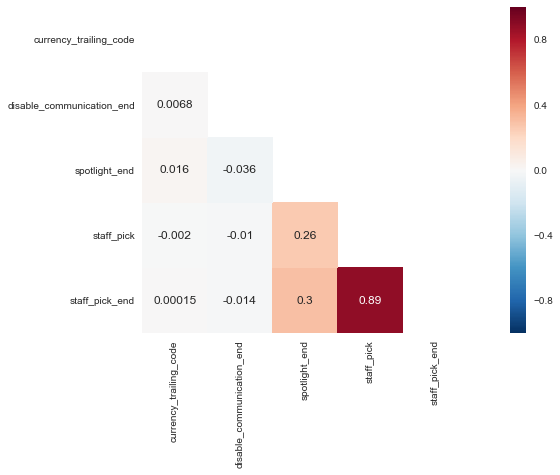

In [44]:
print_corr_heatmap(selected_cols[1:-2])

True

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022E1D6E4C50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000022E25448EB8>]], dtype=object)

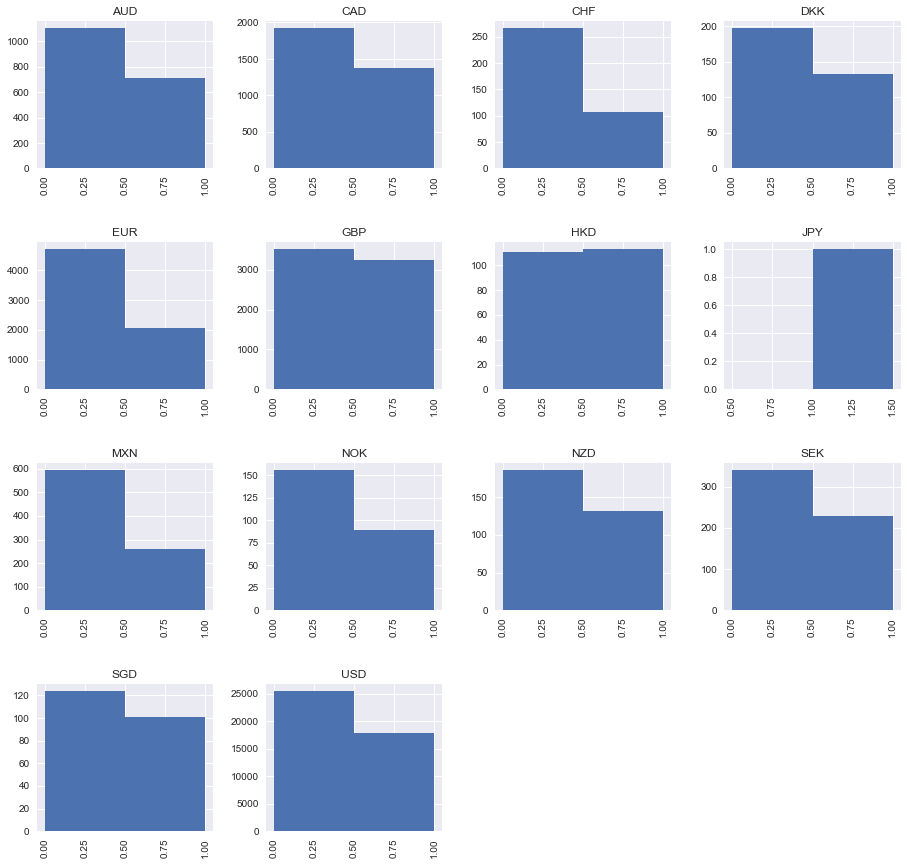

In [46]:
df_projects.hist(column='spotlight_end', bins=2, by='currency', figsize=(15, 15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022E24FCB4A8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000022E277450F0>]], dtype=object)

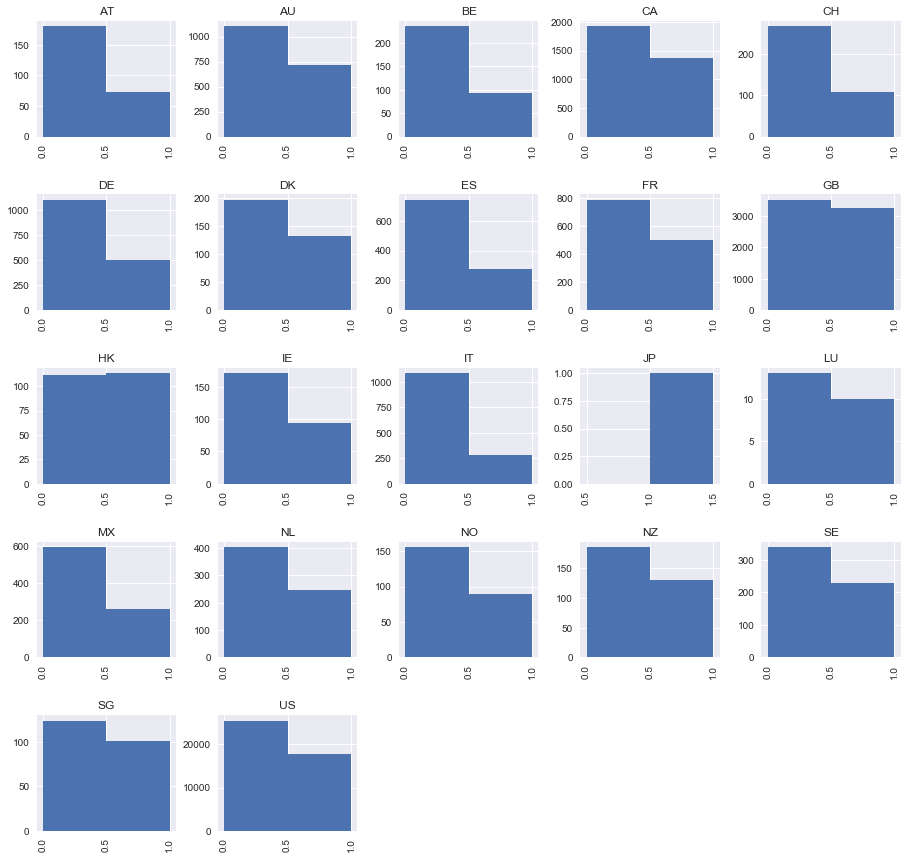

In [47]:
df_projects.hist(column='spotlight_end', bins=2, by='country', figsize=(15, 15))

As we can see, there is a difference in success rate of projects created in different countries or projects collecting money in different currencies. It will probably be helpfull to calculate these success rates for each category.

In [48]:
df_projects.to_csv('projects_acv.csv')

In [49]:
df_projects = pd.read_csv('projects_acv.csv', index_col=0, encoding='cp1252')

### Timestamps

In [50]:
selected_cols = [
    'created_at',
    'launched_at_end',
    'state_changed_at',
    'deadline_end',
    'state_changed_at_end',
    'scraped_at',
    'scraped_at_end',
]

In [51]:
df_projects[selected_cols].head()

,created_at,launched_at_end,state_changed_at,deadline_end,state_changed_at_end,scraped_at,scraped_at_end
0,1444460998,1445121152,1445121152,1448092740,1448092740,1.446387e+09,1.450359e+09
1,1444938006,1445379866,1445379866,1447975466,1447975466,1.446387e+09,1.450359e+09
2,1444906983,1445762846,1445762846,1448326800,1448326800,1.446387e+09,1.450359e+09
3,1444919408,1445626939,1445626939,1450814539,1450814542,1.446387e+09,1.453982e+09
4,1444919408,1445626939,1445626939,1450814539,1450814542,1.450359e+09,1.453982e+09


In [52]:
# no missing values
df_projects[selected_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65038 entries, 0 to 65037
Data columns (total 7 columns):
created_at              65038 non-null int64
launched_at_end         65038 non-null int64
state_changed_at        65038 non-null int64
deadline_end            65038 non-null int64
state_changed_at_end    65038 non-null int64
scraped_at              65038 non-null float64
scraped_at_end          65038 non-null float64
dtypes: float64(2), int64(5)
memory usage: 4.0 MB


In [53]:
df_projects[selected_cols].describe()

,created_at,launched_at_end,state_changed_at,deadline_end,state_changed_at_end,scraped_at,scraped_at_end
count,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04
mean,1.467838e+09,1.472475e+09,1.472475e+09,1.475652e+09,1.475610e+09,1.474094e+09,1.477562e+09
std,2.076627e+07,1.677237e+07,1.677239e+07,1.672703e+07,1.672708e+07,1.669881e+07,1.639163e+07
min,1.266343e+09,1.441143e+09,1.441143e+09,1.446392e+09,1.446392e+09,1.446387e+09,1.450359e+09
25%,1.455334e+09,1.458759e+09,1.458759e+09,1.462058e+09,1.462036e+09,1.460689e+09,1.463290e+09
50%,1.467867e+09,1.471891e+09,1.471891e+09,1.475073e+09,1.474991e+09,1.473914e+09,1.476502e+09
75%,1.483904e+09,1.486687e+09,1.486687e+09,1.489795e+09,1.489787e+09,1.487227e+09,1.492298e+09
max,1.505473e+09,1.505523e+09,1.505523e+09,1.511283e+09,1.508084e+09,1.505539e+09,1.508088e+09


#### Distribution

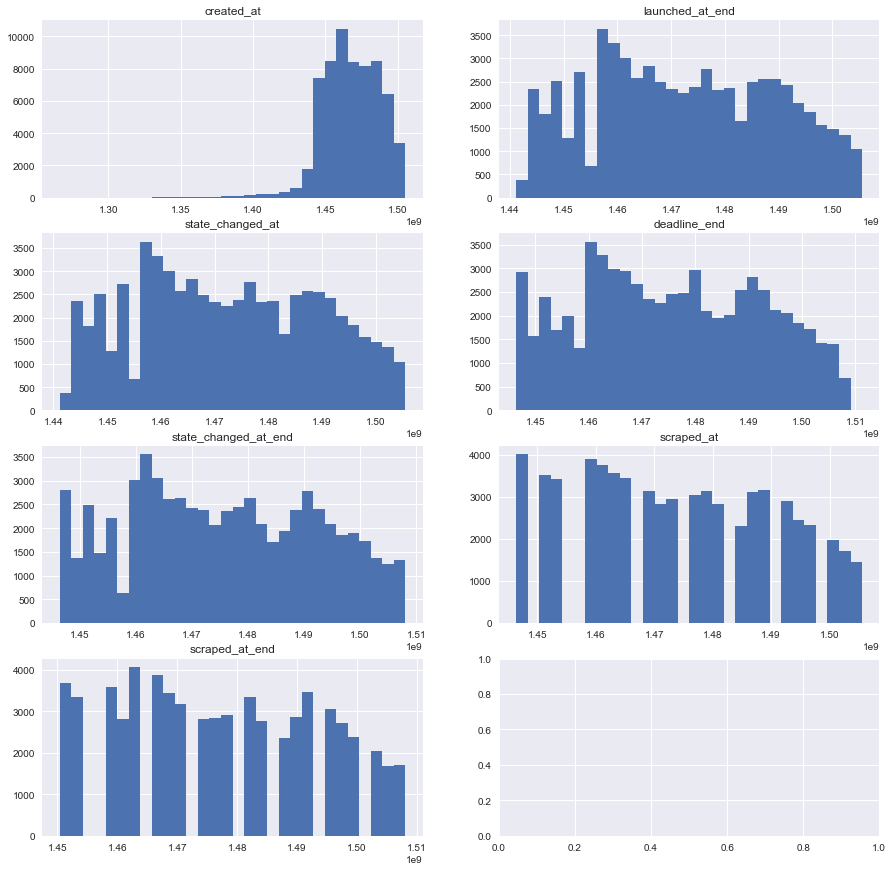

In [54]:
fig, ax = plt.subplots(nrows=4, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(7):
    plt.subplot(4, 2, i+1, title=selected_cols[i])
    plt.hist(df_projects[selected_cols[i]], bins=30)

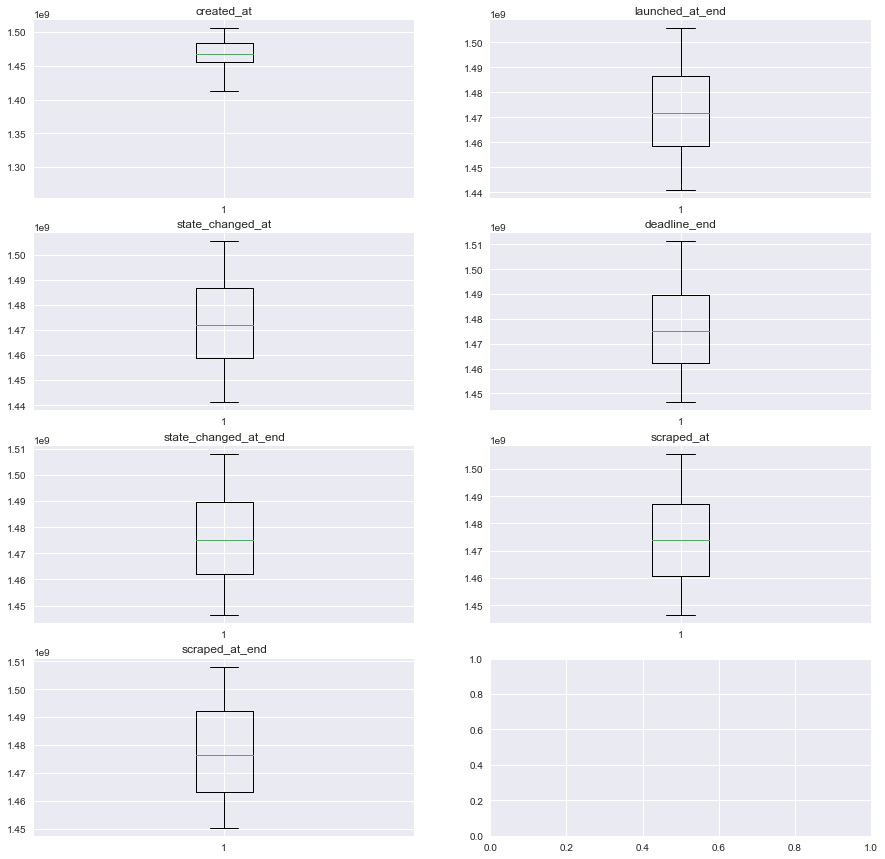

In [55]:
fig, ax = plt.subplots(nrows=4, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(7):
    plt.subplot(4, 2, i+1, title=selected_cols[i])
    plt.boxplot(df_projects[selected_cols[i]])

(1440000000.0, 1455000000.0)

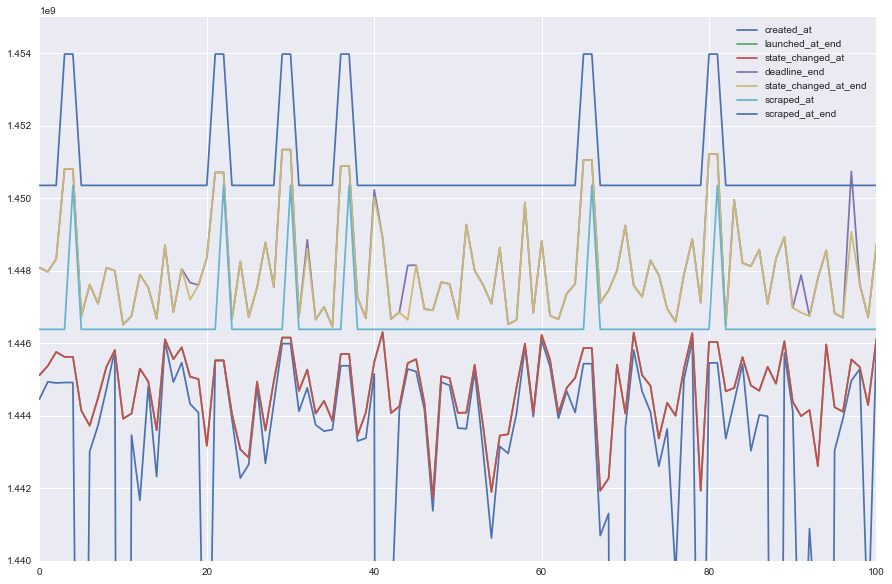

In [56]:
# head
df_projects.loc[:100,selected_cols].plot(figsize=(15,10))
axes = plt.gca()
axes.set_ylim([1.44e9, 1.455e9])

(1500000000.0, 1511000000.0)

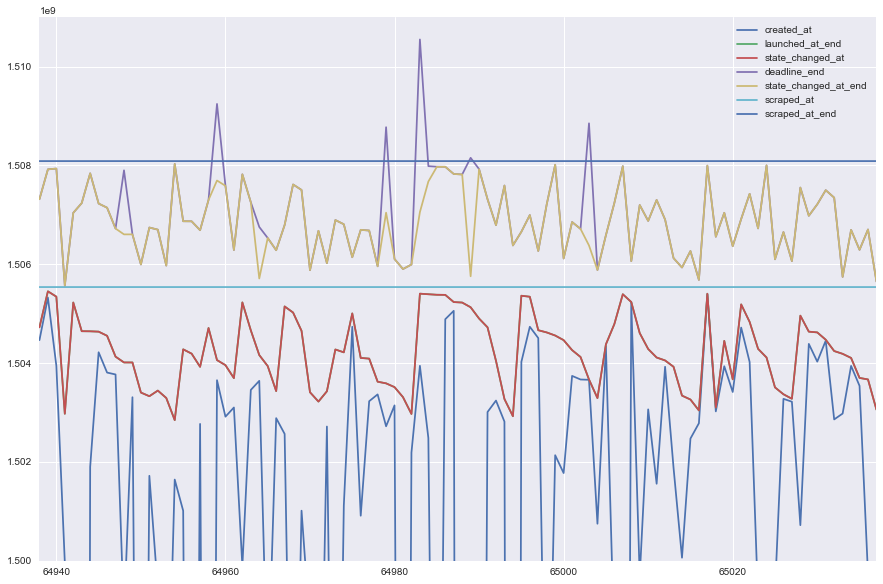

In [57]:
# tail
df_projects.loc[len(df_projects)-100:,selected_cols].plot(figsize=(15,10))
axes = plt.gca()
axes.set_ylim([1.5e9, 1.511e9])

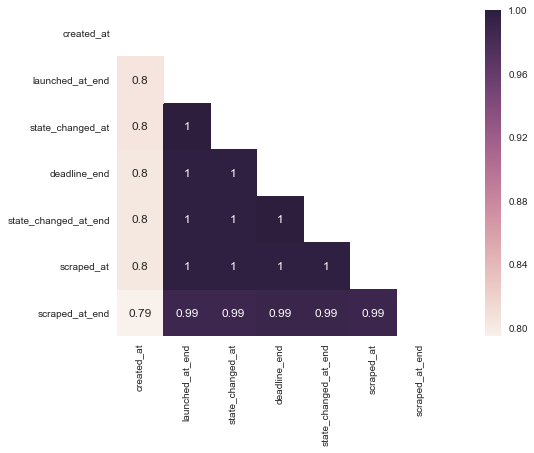

In [58]:
# correlations are high because timestamps are large numbers
print_corr_heatmap(selected_cols)

#### Converting timestamps (days between two events)

In [59]:
min_time = df_projects[selected_cols].min()
min_time.sort_values()

created_at              1.266343e+09
launched_at_end         1.441143e+09
state_changed_at        1.441143e+09
scraped_at              1.446387e+09
deadline_end            1.446392e+09
state_changed_at_end    1.446392e+09
scraped_at_end          1.450359e+09
dtype: float64

In [60]:
selected_cols[:]

['created_at',
 'launched_at_end',
 'state_changed_at',
 'deadline_end',
 'state_changed_at_end',
 'scraped_at',
 'scraped_at_end']

In [61]:
# reading by rows, every column says how many events occured before this event
l = ['col']
l.extend(selected_cols[:-2])
for col1 in selected_cols[:-2]:
    l.append(col1)
    for col2 in selected_cols[:-2]:
        l.append(len(df_projects[df_projects[col1] > df_projects[col2]]))
pd.DataFrame(np.array(l).reshape(6,6))

,0,1,2,3,4,5
0,col,created_at,launched_at_end,state_changed_at,deadline_end,state_changed_at_end
1,created_at,0,0,0,0,0
2,launched_at_end,65038,0,43,0,0
3,state_changed_at,65038,11949,0,0,0
4,deadline_end,65038,65038,65038,0,2501
5,state_changed_at_end,65038,65038,65038,24306,0


Most of the project events are following order:
1. created_at
2. launched_at_end
3. state_changed_at
4. deadline_end
5. state_changed_at_end

scraped_at and scraped_at_end were calculated using datetime of the original csv files provided by webrobots and therefore are not accurate

We can derive:
1. project_duration (deadline_end - launched_at_end)
2. pre_launch_duration (launched_at_end - created_at)
3. days_after_launch (scraped_at - launched_at_end)
4. days_before_deadline

In [62]:
# diff scraped state changed

#### project_duration

In [63]:
df_projects['project_duration'] = df_projects.apply(lambda x: (datetime.fromtimestamp(x['deadline_end']) - datetime.fromtimestamp(x['launched_at_end'])).days, axis=1)

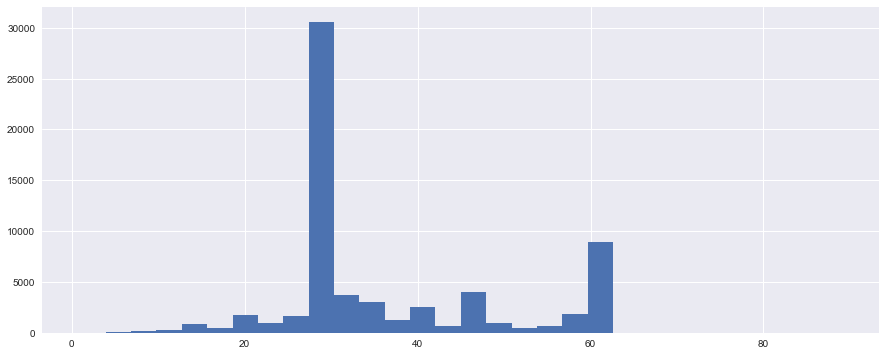

In [64]:
df_projects['project_duration'].hist(bins=30)

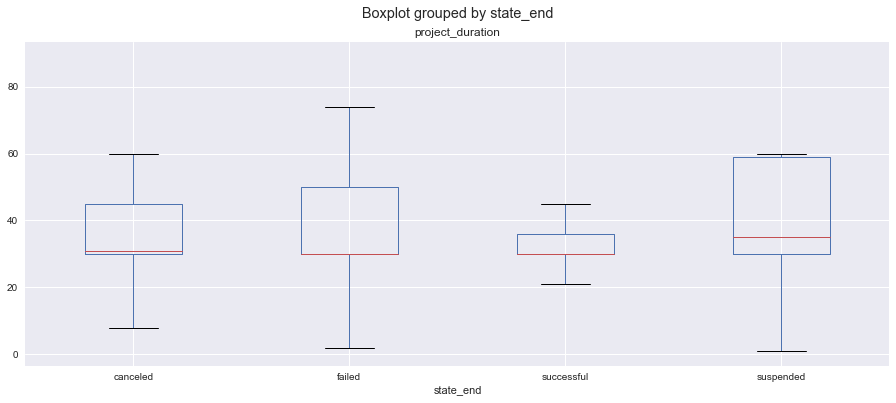

In [65]:
df_projects.boxplot(column='project_duration', by='state_end')

In [66]:
df_projects['project_duration'].min()

1

In [67]:
df_projects['project_duration'].max()

89

In [68]:
# nowadays maximum should be 60 days
# https://www.kickstarter.com/blog/shortening-the-maximum-project-length
# in past it was different (90?)
df_projects['project_duration'].value_counts().sort_index(ascending=False).head(10)

89       1
84       2
74       6
71       2
70       1
64       2
63       2
62       4
60    8943
59    1297
Name: project_duration, dtype: int64

#### pre_launch_duration

In [69]:
df_projects['pre_launch_duration'] = df_projects.apply(lambda x: (datetime.fromtimestamp(x['launched_at_end']) - datetime.fromtimestamp(x['created_at'])).days, axis=1)

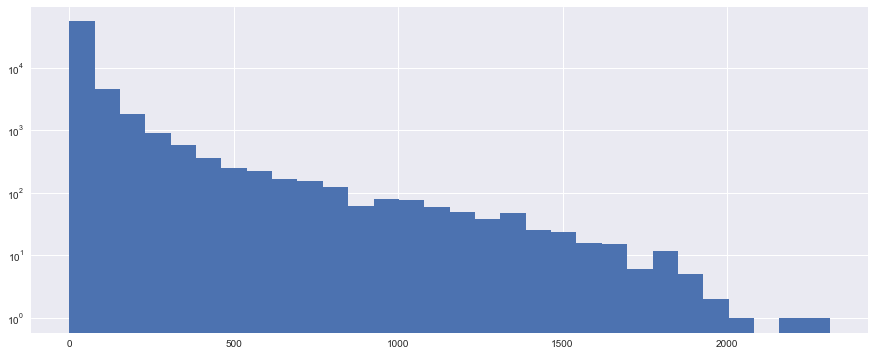

In [70]:
df_projects['pre_launch_duration'].hist(bins=30)
plt.yscale('log')

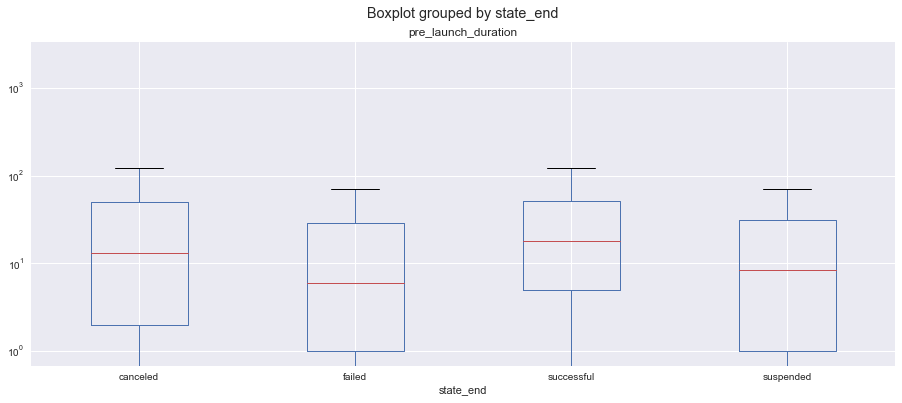

In [71]:
df_projects.boxplot(column='pre_launch_duration', by='state_end')
plt.yscale('log')

#### days_after_launch

In [72]:
df_projects['days_after_launch'] = df_projects.apply(lambda x: (datetime.fromtimestamp(x['scraped_at']) - datetime.fromtimestamp(x['launched_at_end'])).days, axis=1)

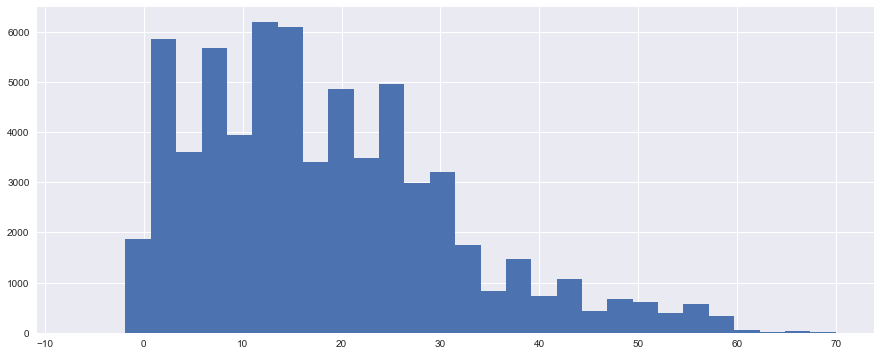

In [73]:
df_projects['days_after_launch'].hist(bins=30)

In [74]:
df_projects['days_after_launch'].min()

-7

In [75]:
df_projects['days_after_launch'].max()

70

In [76]:
df_projects['days_after_launch'].value_counts().sort_index().head(10)

-7       1
-1      26
 0    1834
 1    1955
 2    2108
 3    1784
 4    1746
 5    1855
 6    1789
 7    1815
Name: days_after_launch, dtype: int64

In [77]:
df_projects[df_projects['days_after_launch']<0][['blurb','launched_at_end','days_after_launch']]

,blurb,launched_at_end,days_after_launch
241,A psychedelic journey of coloring-in for adult...,1446388479,-1
249,Help me raise the funds to grow my company and...,1446389578,-1
639,Detroit Bikes is launching its most affordable...,1446391659,-1
795,"Fantini of Denmark is all about elegance, qual...",1446388804,-1
1028,Vertical Growth Inc. is working to open an ind...,1446391164,-1
1173,Sick(er) is a short film written and directed ...,1446389767,-1
1237,After a group of aspiring filmmakers encounter...,1446390555,-1
1891,A feature film about a 12-year-old being raise...,1446390365,-1
3788,An innovative and flexible web-filtering platf...,1446387612,-1
5306,Myself and Holly are going to Japan in April a...,1450359213,-1


## testing state_changed_at

In [ ]:
df_projects['test'] = df_projects.apply(lambda x: (datetime.fromtimestamp(x['state_changed_at']) - datetime.fromtimestamp(x['launched_at_end'])).days, axis=1)

In [ ]:
df_projects['test'].value_counts()

In [ ]:
df_projects[df_projects['test']<0][['name','state_changed_at','test']]

https://www.kickstarter.com/projects/1428469449/instant-hydrator-hydratesall-natural-digestive-ph/updates
https://www.kickstarter.com/projects/1428469449/instant-hydrator-hydratesall-natural-digestive-ph/description

launched 26 Jan
vs
funding period 3 Feb

In [ ]:
df_projects.drop('test', axis=1)

# Second dataset

In [3]:
import mysql.connector as sql
import pandas as pd

In [10]:
df_projects = pd.read_csv('data/projects_merged.csv', encoding='cp1252', index_col=0)

C:\Users\Patrik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
con = sql.connect(database='kickstarter', user='kickstarter', password='kickstarter')

In [5]:
df_db = pd.read_sql('SELECT * FROM kickstarter.kickstarter_project', con, index_col='project_id')
df_db.head()

,url,name,status,project_we_love,category_id,subcategory_id,creator_id,location_id,pledged,goal,...,hours_remaining,description_short,description_full,words_count,videos_count,images_count,faq_count,fb_shares_count,updates_count,comments_count
project_id,,,,,,,,,,,,,,,,,,,,,
1,https://www.kickstarter.com/projects/542421759...,Leaving Finn-gerprints Everywhere,live,0,1,1,1,1,350.0,7300.0,...,1429.170,My name is Finn and I&#39;m transgender male. ...,This fundraiser/project is to directly support...,138,0,1,1,222,1,0
2,https://www.kickstarter.com/projects/167317610...,The NeolithicInspired Studio!,live,0,1,1,2,2,166.0,900.0,...,1265.610,Pledge to my campaign and get one-of-a-kind ce...,I have been working in ceramics for a little o...,216,0,8,0,18,0,1
3,https://www.kickstarter.com/projects/656411291...,PAWfect Paintings Pottery Expansion,live,0,1,1,3,3,50.0,1000.0,...,631.329,Looking to add a ceramics collection to my sho...,My name is Jacqueline Fisher and I am the arti...,121,0,1,0,24,0,0
4,https://www.kickstarter.com/projects/186965087...,"Collective Confluence: A Project Space, NCECA ...",live,0,1,1,4,5,347.0,1500.0,...,378.630,A 3-day participatory exhibition of unfired cl...,The funds raised through this Kickstarter camp...,447,0,1,0,68,0,0
5,https://www.kickstarter.com/projects/154582927...,Meadow Ceramics,live,0,1,1,5,7,29424.0,12000.0,...,333.247,Meadow Ceramics needs a new kiln! Help me rais...,Update 19.02.2016Stretch goal!Â New goal: 30.0...,1349,0,23,0,276,3,1


In [6]:
df_db.tail()

,url,name,status,project_we_love,category_id,subcategory_id,creator_id,location_id,pledged,goal,...,hours_remaining,description_short,description_full,words_count,videos_count,images_count,faq_count,fb_shares_count,updates_count,comments_count
project_id,,,,,,,,,,,,,,,,,,,,,
144607,https://www.kickstarter.com/projects/52092238/...,Help Us Help Artists (Canceled),canceled,0,15,150,120563,369,0.0,100000.0,...,0.0,Our goal - create a venue &amp; stage where co...,Ovations Entertainment Group has been involved...,118,0,1,0,0,0,0
144608,https://www.kickstarter.com/projects/chicagore...,Resurrecting the Legendary New Regal Theater (...,canceled,1,15,150,120598,59,1883.0,100000.0,...,0.0,Help us revive the New Regal Theater as a majo...,The goal of thisÂ project is to reestablish th...,716,0,5,0,0,0,0
144609,https://www.kickstarter.com/projects/geoffblan...,A Stage for Stage Door Theater Company (Canceled),canceled,0,15,150,120599,1393,715.0,1200.0,...,0.0,Stage Door Theater needs a stage for its curre...,"Stage Door Theater Company, under the leadersh...",214,0,1,0,0,4,0
144610,https://www.kickstarter.com/projects/grindhous...,Pueblo Underground Theater (Canceled),canceled,0,15,150,120600,3615,605.0,400000.0,...,0.0,I want to purchase the former Bread Of Life Ch...,I have often dreamed of running my own theater...,405,0,1,3,0,0,2
144611,https://www.kickstarter.com/projects/amanda-do...,N/A (Canceled),canceled,0,15,150,120601,12522,0.0,1500000.0,...,0.0,N/A,N/A,1,0,1,0,0,0,0


In [7]:
df_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144611 entries, 1 to 144611
Data columns (total 25 columns):
url                  144611 non-null object
name                 144610 non-null object
status               144611 non-null object
project_we_love      144611 non-null int64
category_id          144611 non-null int64
subcategory_id       144611 non-null int64
creator_id           144611 non-null int64
location_id          144611 non-null int64
pledged              144611 non-null float64
goal                 144611 non-null float64
currency             144611 non-null object
backers_count        144611 non-null int64
duration             144611 non-null int64
start_time           61191 non-null object
end_time             144594 non-null object
hours_remaining      144611 non-null float64
description_short    144611 non-null object
description_full     144611 non-null object
words_count          144611 non-null int64
videos_count         144611 non-null int64
images_count    

In [13]:
# project_id is sequence but we could use url for merging with first dataset
df_db.loc[1, 'url'].split('/')[5]

'leaving-finn-gerprints-everywhere'

In [12]:
df_projects.loc[1, 'url_name']

'all-style-dance-battle-the-streak'

In [14]:
# get project_url
df_db['url_name'] = df_db.apply(lambda x: x['url'].split('/')[5], axis=1)

In [15]:
df_projects.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65038 entries, 0 to 65037
Data columns (total 68 columns):
backers_count                65038 non-null int64
backers_count_end            65038 non-null int64
blurb                        65038 non-null object
blurb_end                    65036 non-null object
category                     65038 non-null object
category_end                 65038 non-null object
category_name                65038 non-null object
category_name_end            65038 non-null object
category_parent              65038 non-null object
category_parent_end          65038 non-null object
category_position            65038 non-null int64
category_position_end        65038 non-null int64
country                      65038 non-null object
created_at                   65038 non-null int64
creator                      65038 non-null object
creator_end                  65038 non-null object
creator_name                 65037 non-null object
creator_name_end             

In [16]:
df_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144611 entries, 1 to 144611
Data columns (total 26 columns):
url                  144611 non-null object
name                 144610 non-null object
status               144611 non-null object
project_we_love      144611 non-null int64
category_id          144611 non-null int64
subcategory_id       144611 non-null int64
creator_id           144611 non-null int64
location_id          144611 non-null int64
pledged              144611 non-null float64
goal                 144611 non-null float64
currency             144611 non-null object
backers_count        144611 non-null int64
duration             144611 non-null int64
start_time           61191 non-null object
end_time             144594 non-null object
hours_remaining      144611 non-null float64
description_short    144611 non-null object
description_full     144611 non-null object
words_count          144611 non-null int64
videos_count         144611 non-null int64
images_count    

In [17]:
# merge first and second dataset
df_merged = df_projects.merge(df_db, on='url_name')

In [18]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9483 entries, 0 to 9482
Data columns (total 93 columns):
backers_count_x              9483 non-null int64
backers_count_end            9483 non-null int64
blurb                        9483 non-null object
blurb_end                    9483 non-null object
category                     9483 non-null object
category_end                 9483 non-null object
category_name                9483 non-null object
category_name_end            9483 non-null object
category_parent              9483 non-null object
category_parent_end          9483 non-null object
category_position            9483 non-null int64
category_position_end        9483 non-null int64
country                      9483 non-null object
created_at                   9483 non-null int64
creator                      9483 non-null object
creator_end                  9483 non-null object
creator_name                 9482 non-null object
creator_name_end             9482 non-null objec

In [ ]:
df_merged.to_csv('data/merged.csv')

In [20]:
x = df_projects[~df_projects['id'].isin(df_merged['id'])]
#x.loc[380, 'project_url']

In [21]:
x

,backers_count,backers_count_end,blurb,blurb_end,category,category_end,category_name,category_name_end,category_parent,category_parent_end,...,state_end,static_usd_rate,static_usd_rate_end,urls,urls_end,urls_url,urls_url_end,usd_pledged,usd_pledged_end,url_name
6,218,310,Finally we have a building but we need your he...,Finally we have a building but we need your he...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Spaces,Spaces,dance,dance,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/988974145...,https://www.kickstarter.com/projects/988974145...,6820.000000,8861.000000,the-posh-factory
72,24,37,"I am organizing a 10,000 domino creation at th...","I am organizing a 10,000 domino creation at th...","{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Performance Art,Performance Art,art,art,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/131387503...,https://www.kickstarter.com/projects/131387503...,590.000000,1055.000000,the-ithaca-domino-project
134,22,32,The Fire Ball Masquerade is the biggest and fr...,The Fire Ball Masquerade is the biggest and fr...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Performance Art,Performance Art,art,art,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/307469837...,https://www.kickstarter.com/projects/307469837...,5456.000000,6910.000000,fire-ball-viii-the-8th-wonder-of-the-world
203,11,26,help me build an amazing studio so i can keep ...,help me build an amazing studio so i can keep ...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Sculpture,Sculpture,art,art,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/134687581...,https://www.kickstarter.com/projects/134687581...,620.000000,1196.000000,living-as-an-artist
229,1,2,Make this Christmas/holiday season a retro one!,Make this Christmas/holiday season a retro one!,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Textiles,Textiles,art,art,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/carlwilli...,https://www.kickstarter.com/projects/carlwilli...,17.000000,31.000000,video-game-perler-christmas-ornaments
277,24,97,Bobby is the first creature from the world of ...,Bobby is the first creature from the world of ...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Sculpture,Sculpture,art,art,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/161464728...,https://www.kickstarter.com/projects/161464728...,3134.000000,13163.000000,creepy-hill-bobby-collectible-toy-figure
313,64,78,Make your own light-up pop-up greeting cards w...,Make your own light-up pop-up greeting cards w...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",DIY,DIY,crafts,crafts,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.ki

In [22]:
x = x.drop_duplicates(subset='id')
x

,backers_count,backers_count_end,blurb,blurb_end,category,category_end,category_name,category_name_end,category_parent,category_parent_end,...,state_end,static_usd_rate,static_usd_rate_end,urls,urls_end,urls_url,urls_url_end,usd_pledged,usd_pledged_end,url_name
6,218,310,Finally we have a building but we need your he...,Finally we have a building but we need your he...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Spaces,Spaces,dance,dance,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/988974145...,https://www.kickstarter.com/projects/988974145...,6820.000000,8861.000000,the-posh-factory
72,24,37,"I am organizing a 10,000 domino creation at th...","I am organizing a 10,000 domino creation at th...","{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Performance Art,Performance Art,art,art,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/131387503...,https://www.kickstarter.com/projects/131387503...,590.000000,1055.000000,the-ithaca-domino-project
134,22,32,The Fire Ball Masquerade is the biggest and fr...,The Fire Ball Masquerade is the biggest and fr...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Performance Art,Performance Art,art,art,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/307469837...,https://www.kickstarter.com/projects/307469837...,5456.000000,6910.000000,fire-ball-viii-the-8th-wonder-of-the-world
203,11,26,help me build an amazing studio so i can keep ...,help me build an amazing studio so i can keep ...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Sculpture,Sculpture,art,art,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/134687581...,https://www.kickstarter.com/projects/134687581...,620.000000,1196.000000,living-as-an-artist
229,1,2,Make this Christmas/holiday season a retro one!,Make this Christmas/holiday season a retro one!,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Textiles,Textiles,art,art,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/carlwilli...,https://www.kickstarter.com/projects/carlwilli...,17.000000,31.000000,video-game-perler-christmas-ornaments
277,24,97,Bobby is the first creature from the world of ...,Bobby is the first creature from the world of ...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Sculpture,Sculpture,art,art,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/161464728...,https://www.kickstarter.com/projects/161464728...,3134.000000,13163.000000,creepy-hill-bobby-collectible-toy-figure
313,64,78,Make your own light-up pop-up greeting cards w...,Make your own light-up pop-up greeting cards w...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",DIY,DIY,crafts,crafts,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.ki

In [24]:
x = x.drop_duplicates(subset='urls_url')
x

,backers_count,backers_count_end,blurb,blurb_end,category,category_end,category_name,category_name_end,category_parent,category_parent_end,...,state_end,static_usd_rate,static_usd_rate_end,urls,urls_end,urls_url,urls_url_end,usd_pledged,usd_pledged_end,url_name
6,218,310,Finally we have a building but we need your he...,Finally we have a building but we need your he...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Spaces,Spaces,dance,dance,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/988974145...,https://www.kickstarter.com/projects/988974145...,6820.000000,8861.000000,the-posh-factory
72,24,37,"I am organizing a 10,000 domino creation at th...","I am organizing a 10,000 domino creation at th...","{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Performance Art,Performance Art,art,art,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/131387503...,https://www.kickstarter.com/projects/131387503...,590.000000,1055.000000,the-ithaca-domino-project
134,22,32,The Fire Ball Masquerade is the biggest and fr...,The Fire Ball Masquerade is the biggest and fr...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Performance Art,Performance Art,art,art,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/307469837...,https://www.kickstarter.com/projects/307469837...,5456.000000,6910.000000,fire-ball-viii-the-8th-wonder-of-the-world
203,11,26,help me build an amazing studio so i can keep ...,help me build an amazing studio so i can keep ...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Sculpture,Sculpture,art,art,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/134687581...,https://www.kickstarter.com/projects/134687581...,620.000000,1196.000000,living-as-an-artist
229,1,2,Make this Christmas/holiday season a retro one!,Make this Christmas/holiday season a retro one!,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Textiles,Textiles,art,art,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/carlwilli...,https://www.kickstarter.com/projects/carlwilli...,17.000000,31.000000,video-game-perler-christmas-ornaments
277,24,97,Bobby is the first creature from the world of ...,Bobby is the first creature from the world of ...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",Sculpture,Sculpture,art,art,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.kickstarter.com...",https://www.kickstarter.com/projects/161464728...,https://www.kickstarter.com/projects/161464728...,3134.000000,13163.000000,creepy-hill-bobby-collectible-toy-figure
313,64,78,Make your own light-up pop-up greeting cards w...,Make your own light-up pop-up greeting cards w...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",DIY,DIY,crafts,crafts,...,successful,1.000000,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...","{""web"":{""project"":""https://www.ki

In [39]:
x.sort_values(by=['deadline_end'], inplace=True)

In [40]:
x['urls_url'].value_counts()

https://www.kickstarter.com/projects/751354741/brother-hack-thyself-lgbt-community-building-app           1
https://www.kickstarter.com/projects/cncwoodsmith/character-crate                                         1
https://www.kickstarter.com/projects/683614520/the-s-wood-project-part-one-s-wood-mini                    1
https://www.kickstarter.com/projects/1418134969/duo-amaral-key-west                                       1
https://www.kickstarter.com/projects/978013621/prince-of-wolves                                           1
https://www.kickstarter.com/projects/briannabening/core-denim-co                                          1
https://www.kickstarter.com/projects/1920409577/zoe-horror-escape-game                                    1
https://www.kickstarter.com/projects/1952211219/escape-from-sunset-island-revival-edition                 1
https://www.kickstarter.com/projects/189607442/press-gravity-tapes                                        1
https://www.kickstarter.com/

In [41]:
x['urls_url'].to_csv('urls.csv', index=False)

In [42]:
df_merged['state_end'].value_counts()

failed        6674
successful    2333
canceled       448
suspended       28
Name: state_end, dtype: int64